In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import seaborn as sns
import pickle
sns.set_context('poster')
import glob
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, plot_roc_curve
from scipy.stats import pearsonr, spearmanr
from scipy.stats import wasserstein_distance
import os
import gn4pions.modules.resolution_util as ru
import gn4pions.modules.plot_util as pu
import atlas_mpl_style as ampl
ampl.use_atlas_style()
plt.style.use('print')
ampl.set_color_cycle('Oceanic',10)

In [2]:
# data_dir = 'results/no_cuts/full_dataset_with_tracks_20220307/'
# data_dir = 'results/cuts/full_dataset_20220307/'
# data_dir = 'results/no_cuts_clusters_only/full_dataset_20220308/'
# data_dir = 'results/onetrack_multicluster/full_dataset_20220314/'
data_dir = 'results/onetrack_multicluster_hadweight/full_dataset_20220314/'

Loading from results/onetrack_multicluster_hadweight/full_dataset_20220314/


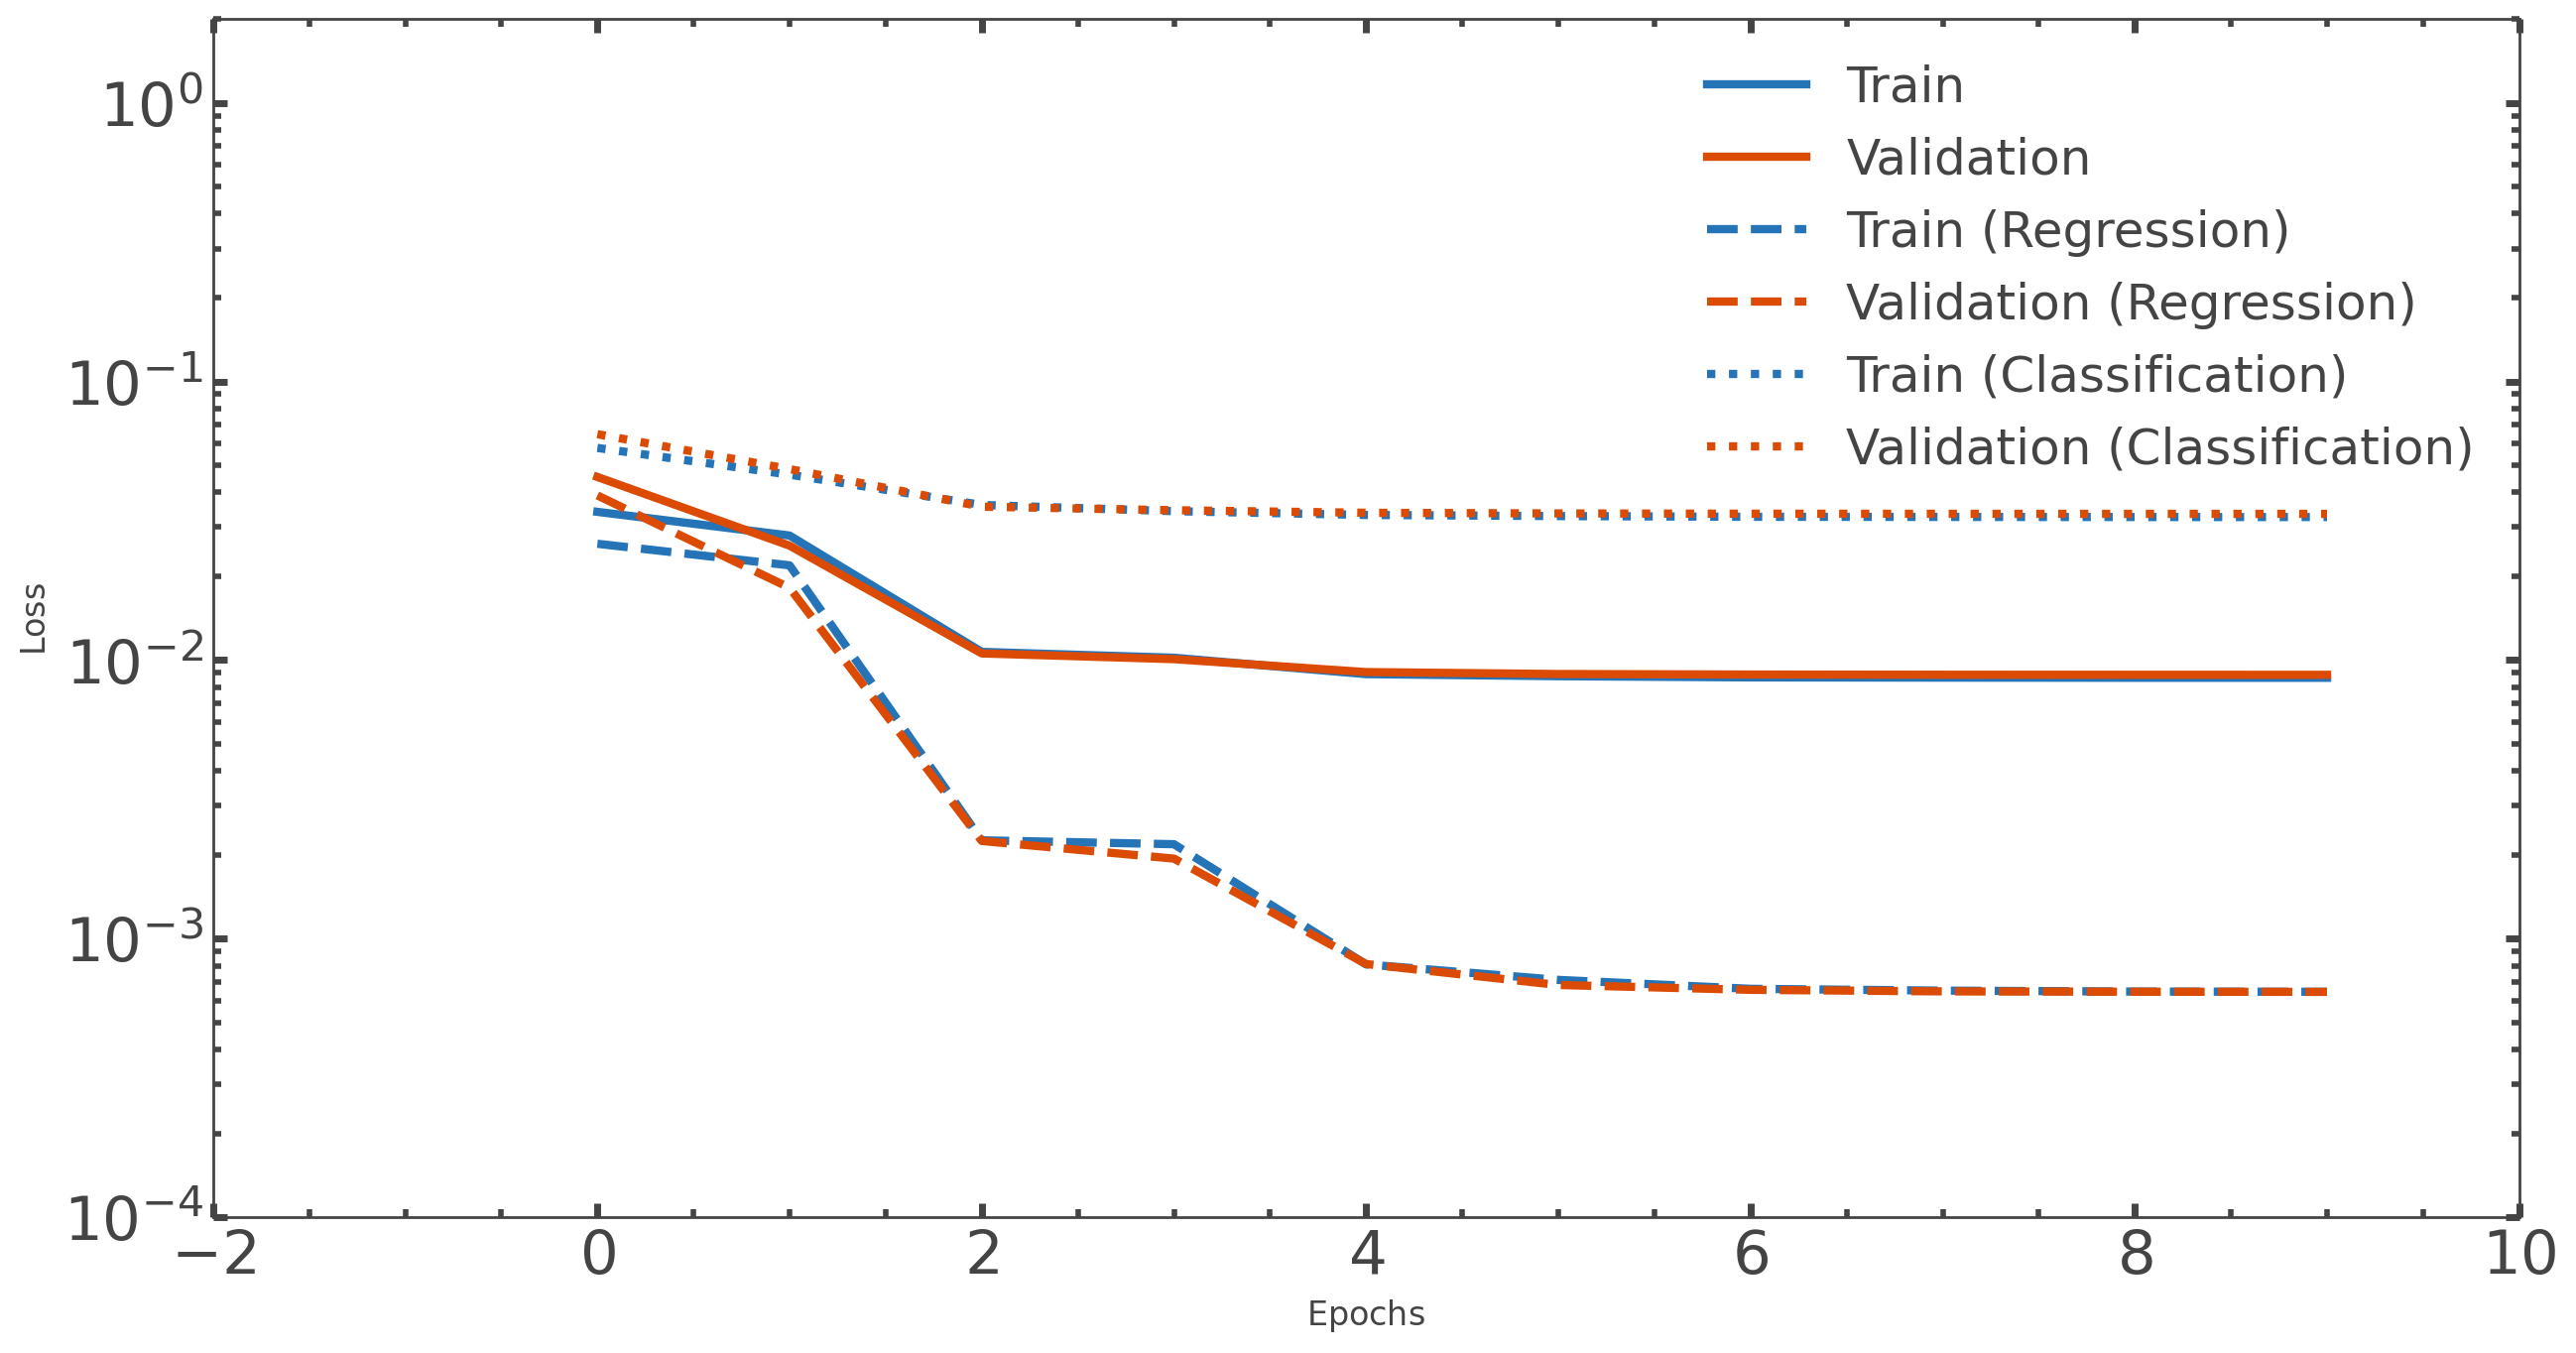

In [3]:
pion_list = ['pion']
sym_list = ['+-',]
concat_type = ['False']
model_name = ['ConcatFalse']
line = ['-', '--', ':']
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

plt.figure(figsize=(15,8))
hist_files = np.sort(glob.glob(data_dir + 'losses.npz'))
print('Loading from {}'.format(data_dir))


hist = np.load(hist_files[0])
plt.semilogy(hist['training'].mean(axis=1), color=blues[5, :3], 
             label=r'Train', linestyle=line[0])
plt.semilogy(hist['validation'].mean(axis=1), color=oranges[5, :3], 
             label=r'Validation', linestyle=line[0])

plt.semilogy(hist['training_regress'].mean(axis=1), color=blues[5, :3], 
             label=r'Train (Regression)', linestyle=line[1])
plt.semilogy(hist['validation_regress'].mean(axis=1), color=oranges[5, :3], 
             label=r'Validation (Regression)', linestyle=line[1])

plt.semilogy(hist['training_class'].mean(axis=1), color=blues[5, :3], 
             label=r'Train (Classification)', linestyle=line[2])
plt.semilogy(hist['validation_class'].mean(axis=1), color=oranges[5, :3], 
             label=r'Validation (Classification)', linestyle=line[2])


plt.ylabel(r'$Loss$')
plt.xlabel(r'$Epochs$')
plt.ylim([1e-4, 2])
# sns.despine()
plt.legend(loc="upper right", fontsize=18)
plt.savefig(data_dir+'/training_mse.png', bbox_inches='tight', dpi=300)
plt.show()

# Load data

### Classification

In [ ]:
### East Bay GNN, clusters only
pred_file = 'pub_note_results/validation_data_predictions_multiJobTraining_wClusterEcut.npz' # classification & combined
# pred_file = 'pub_note_results/validation_data_predictions_multiJobTraining.npz' # regression only

predictions = np.load(pred_file, allow_pickle=True)
targets_regress = predictions['cluster_ENG_CALIB_TOT']
targets_class = predictions['pion_type']
outputs_regress = predictions['pred_cluster_ENG_CALIB_TOT']
outputs_class = predictions['pred_prob']
energies = predictions['cluster_ENG_CALIB_TOT']
etas = predictions['cluster_Eta']
em_probs = predictions['cluster_EM_PROBABILITY']

df = pd.DataFrame(np.vstack(
    [targets_class, outputs_class, targets_regress, outputs_regress, energies, etas, em_probs]).T, 
        columns = ["targets_class", "outputs_class", 
                  "targets_regress", "outputs_regress", "energy", "eta", "em_prob"])

df.targets_class = df.targets_class.replace('pion',1)
df.targets_class = df.targets_class.replace('pi0',0)
df.targets_regress = df.targets_regress.astype(float)
df.outputs_regress = df.outputs_regress.astype(float)

In [ ]:
### PFN 
pfn = np.load('pub_note_results/PFN_class_preds_1_10_fixed.npz')
df_pfn = pd.DataFrame(np.vstack(
    [pfn['target'], pfn['predictions'], pfn['energy'], pfn['eta']]).T, 
    columns = ["targets_class", "outputs_class", "energy", "eta"])

In [ ]:
### CNN
cnn = np.load('pub_note_results/cnn_classifier.npz')
cnn['arr_0'].shape
df_cnn = pd.DataFrame(cnn['arr_0'], 
    columns = ["targets_class", "outputs_class", "eta", "energy", "true_energy"])

### Regression

In [4]:
### East Bay GNN w/ tracks
pred_file = data_dir+'/predictions.npz'
predictions = np.load(pred_file)
# print(predictions.files)
targets_regress = predictions['targets'][:, 0]
targets_class = predictions['targets'][:, 1]
outputs_regress = predictions['outputs'][:, 0]
outputs_class = predictions['outputs'][:, 1]
energies = predictions['energies']
etas = predictions['etas']
em_probs = predictions['em_probs']
cluster_calib_e = predictions['cluster_calib_es']
cluster_had_weight = predictions['cluster_had_weights']

df = pd.DataFrame(np.vstack(
    [targets_class, outputs_class, targets_regress, outputs_regress, energies, etas, em_probs,
    cluster_calib_e, cluster_had_weight
    ]).T, 
                 columns = ["targets_class", "outputs_class", "targets_regress", "outputs_regress", 
                            "energy", "eta", "em_prob", "cluster_calib_e",  "cluster_had_weight"
                           ])

In [16]:
### DeepSets with tracks
russell = np.load('pub_note_results/target_preds_PFN_base_STMC--LR_1e-03--BS_1800--EP_800--EV_200000--2022-03-11.npz')
russell.files
df_russell = pd.DataFrame(np.vstack(
    [russell['args'][0,:], russell['args'][1,:], russell['args'][2,:]]).T, 
    columns = ["targets_regress", "outputs_regress", "eta"])

tnet = np.load('pub_note_results/target_preds_PFN_wTNet_STMC--LR_1e-03--BS_1800--EP_800--EV_200000--2022-03-11.npz')
df_tnet = pd.DataFrame(np.vstack(
    [tnet['args'][0,:], tnet['args'][1,:], tnet['args'][1,:]]).T, 
    columns = ["targets_regress", "outputs_regress", "eta"])

In [19]:
### Sanmay
edgeconv = np.load('pub_note_results/EdgeConv_Prediction.npz')
df_edgeconv = pd.DataFrame(np.vstack([edgeconv['target'],edgeconv['prediction']]).T, columns=["targets_regress", "outputs_regress"])
transformer = np.load('pub_note_results/Attention_Prediction.npz')
df_transformer = pd.DataFrame(np.vstack([transformer['target'],transformer['prediction']]).T, columns=["targets_regress", "outputs_regress"])

# Make plots

## Classification

In [ ]:
# acc = []
# for i in np.arange(0, 1, .01):
#     acc.append(accuracy_score(df.targets_class, df.outputs_class>i))
# plt.plot(np.arange(0, 1, .01), acc, color="crimson")
# plt.xlabel('Threshold')
# plt.ylabel('Classification Accuracy')
# plt.grid()
# plt.savefig(data_dir+'/acc_threshold.png', bbox_inches='tight', dpi=300)
# plt.show()
# print('Max Acc: {:.3f} at {:.2f}'.format(100*np.max(acc), np.argmax(acc)*.01))

# acc = accuracy_score(df.targets_class, df.outputs_class>.5)
# prec = precision_score(df.targets_class, df.outputs_class>.5)
# recall = recall_score(df.targets_class, df.outputs_class>.5)
# f1 = f1_score(df.targets_class, df.outputs_class>.5)

# print('Acc:\t{:.3f}\nPrec:\t{:.3f}\nRecall:\t{:.3f}\nF1:\t{:.3f}'.format(acc, prec, recall, f1))

In [ ]:
fpr_em_prob, tpr_em_prob, _ = roc_curve(df[(df.em_prob > 0) & (np.abs(df.eta) < 0.7)].targets_class, 1-df[(df.em_prob > 0) & (np.abs(df.eta) < 0.7)].em_prob)
df_roc = pd.DataFrame(np.vstack([tpr_em_prob,fpr_em_prob]).T, columns=["tpr","fpr"])
print("Rejection @ {:.0f}% efficiency: {:.3f}".format(0.95*100,1/df_roc[df_roc.tpr > 0.95].fpr.iloc[0]))

In [ ]:
def get_rejection(df, eff=0.95):
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    df_roc = pd.DataFrame(np.vstack([tpr,fpr]).T, columns=["tpr","fpr"])
    print("Rejection @ {:.0f}% efficiency: {:.3f}".format(eff*100,1/df_roc[df_roc.tpr > eff].fpr.iloc[0]))
    
def make_classification_plots(df, data_dir=".", save_label="", plot_label="GNN"): 
    ### Confusion matrix 
    cm = confusion_matrix(df.targets_class, df.outputs_class>0.5, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=['$\\pi^{0}$', '$\\pi^{\pm}$'])
    disp.plot(values_format='.3f')
    plt.savefig(data_dir+'/'+save_label+'_cm.png', dpi=300, bbox_inches='tight')
    plt.show()

    ### ROC curve
    plt.figure()
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    roc_auc = auc(fpr, tpr)
    disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    disp.plot()
#     plt.plot(fpr, tpr)
#     plt.plot([-.2, 1.2], [-.2, 1.2], 'k')
    plt.axis('square')
    plt.xlim([-.1, 1.1])
    plt.ylim([-.1, 1.1])
    plt.grid()
    plt.savefig(data_dir+'/'+save_label+'_roc_auc.png', dpi=300, bbox_inches='tight')
    plt.show()

    ### Rejection @ 95% efficiency
    df_roc = pd.DataFrame(np.vstack([tpr,fpr]).T, columns=["tpr","fpr"])
    print("Rejection @ 95% efficiency:",1/df_roc[df_roc.tpr > 0.95].fpr.iloc[0])
    
    ### NN scores
    plt.figure()
    plt.hist(df[df.targets_class == 0].outputs_class, 50, density=True, histtype='step', linewidth=2, label='$\\pi^{0}$')
    plt.hist(df[df.targets_class == 1].outputs_class, 50, density=True, histtype='step', linewidth=2, label='$\\pi^{\\pm}$')
    plt.legend(loc='upper center')
    plt.legend()
    plt.xlabel('Classifier Output')
    plt.yscale('log')
    plt.savefig(data_dir+'/'+save_label+'_class_dist.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    ### Bins of energy
    plt.figure(dpi=150)
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    fpr_bin0, tpr_bin0, _ = roc_curve(df[df.energy < 1].targets_class, 
                                      df[df.energy < 1].outputs_class)
    fpr_bin1, tpr_bin1, _ = roc_curve(df[(df.energy > 1) & (df.energy < 10)].targets_class, 
                                      df[(df.energy > 1) & (df.energy < 10)].outputs_class)
    fpr_bin2, tpr_bin2, _ = roc_curve(df[(df.energy > 10) & (df.energy < 50)].targets_class, 
                                      df[(df.energy > 10) & (df.energy < 50)].outputs_class)
    fpr_bin3, tpr_bin3, _ = roc_curve(df[(df.energy > 50) & (df.energy < 500)].targets_class, 
                                      df[(df.energy > 50) & (df.energy < 500)].outputs_class)
    plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = plot_label+" (50 < Cluster Energy / GeV < 500)",linestyle="dashed")
    plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = plot_label+" (10 < Cluster Energy / GeV < 50)",linestyle="dotted")
    plt.plot(tpr, np.nan_to_num(1/fpr),label = plot_label+" (All energies)",)
    plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = plot_label+" (1 < Cluster Energy / GeV < 10)",linestyle="dashdot")
    plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = plot_label+" (Cluster Energy < 1 GeV)")
    plt.xlim(0.5,1)
    plt.yscale('log')
    plt.ylim(0,3000)
    plt.tick_params(labelsize=14)
    ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency");
    ampl.set_ylabel(r"$\pi^0$ Rejection");
    ampl.plot.draw_atlas_label(0.6,0.95, status='int', simulation=True, desc=r"Classification of $\pi^{\pm}$ vs. $\pi^0$")
    plt.legend(loc="lower left", fontsize=14);
    plt.savefig(data_dir+'/'+save_label+'_energy_bins.png', bbox_inches='tight')
    
    
    ### Bins of eta
    plt.figure(dpi=150)
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    fpr_bin0, tpr_bin0, _ = roc_curve(df[np.abs(df.eta) < 0.8].targets_class, 
                                      df[np.abs(df.eta) < 0.8].outputs_class)
    fpr_bin1, tpr_bin1, _ = roc_curve(df[(np.abs(df.eta) > 0.8) & (np.abs(df.eta) < 1.37)].targets_class, 
                                      df[(np.abs(df.eta) > 0.8) & (np.abs(df.eta) < 1.37)].outputs_class)
    fpr_bin2, tpr_bin2, _ = roc_curve(df[(np.abs(df.eta) > 1.37) & (np.abs(df.eta) < 2.5)].targets_class, 
                                      df[(np.abs(df.eta) > 1.37) & (np.abs(df.eta) < 2.5)].outputs_class)
    fpr_bin3, tpr_bin3, _ = roc_curve(df[np.abs(df.eta) > 2.5].targets_class, 
                                      df[np.abs(df.eta) > 2.5].outputs_class)
    plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = plot_label+" ($|\eta|$ > 2.5)",linestyle="dashed")
    plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = plot_label+" ($|\eta|$ < 0.8)",linestyle="dotted")
    plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = plot_label+" (0.8 < $|\eta|$ < 1.37)",)
    plt.plot(tpr, np.nan_to_num(1/fpr),label = plot_label+" (All $\eta$ values)", linestyle="dashdot")
    plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = plot_label+" (1.37 < $|\eta|$ < 2.5)",)
    plt.xlim(0.7,1)
    plt.yscale('log')
    plt.ylim(0,500)
    plt.tick_params(labelsize=14)
    ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency");
    ampl.set_ylabel(r"$\pi^0$ Rejection");
    ampl.plot.draw_atlas_label(0.6,0.95, status='int', simulation=True, desc=r"Classification of $\pi^{\pm}$ vs. $\pi^0$")
    plt.legend(loc="lower left", fontsize=14);
    plt.savefig(data_dir+'/'+save_label+'_eta_bins.png', bbox_inches='tight')

In [ ]:
get_rejection(df_pfn[np.abs(df_pfn.eta)<0.7])

In [ ]:
make_classification_plots(df, 
#                           data_dir="./pub_note_results", 
                          save_label="gnn", 
                          plot_label="GNN")

In [ ]:
def make_class_comparison_plot(df, df_pfn, df_cnn=None, data_dir="."): 
    fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
    fpr_em_prob, tpr_em_prob, _ = roc_curve(df[df.em_prob > 0].targets_class, 1-df[df.em_prob > 0].em_prob)
    fpr_pfn, tpr_pfn, _ = roc_curve(df_pfn.targets_class, df_pfn.outputs_class)
    if df_cnn is not None:
        fpr_cnn, tpr_cnn, _ = roc_curve(df_cnn.targets_class, df_cnn.outputs_class)
        cnn_rejection_ratios = []
   
    gnn_rejection_ratios = []
    pfn_rejection_ratios = []
    for i in tqdm(tpr_em_prob):
        em_prob_rejection = np.nan_to_num(1/np.mean(fpr_em_prob[np.where(tpr_em_prob==i)]))
        gnn_closest_index = tpr[np.argmin(np.abs(tpr-i))]
        gnn_rejection = np.nan_to_num(1/np.mean(fpr[np.where(tpr==gnn_closest_index)]))
        gnn_rejection_ratios.append(gnn_rejection/em_prob_rejection)
        pfn_closest_index = tpr_pfn[np.argmin(np.abs(tpr_pfn-i))]
        pfn_rejection = np.nan_to_num(1/np.mean(fpr_pfn[np.where(tpr_pfn==pfn_closest_index)]))
        pfn_rejection_ratios.append(pfn_rejection/em_prob_rejection)
        if df_cnn is not None:
            cnn_closest_index = tpr_cnn[np.argmin(np.abs(tpr_cnn-i))]
            cnn_rejection = np.nan_to_num(1/np.mean(fpr_cnn[np.where(tpr_cnn==cnn_closest_index)]))
            cnn_rejection_ratios.append(cnn_rejection/em_prob_rejection)
        
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw = {'height_ratios':[3, 1]}, 
                           figsize=(8, 6), 
    #                        constrained_layout=True
                          )
    ax[0].plot(tpr_em_prob, np.nan_to_num(1/fpr_em_prob),linewidth=2, label = r"$\mathscr{P}^{EM}_{clus}$", linestyle="dashed")
    ax[0].plot(tpr_pfn, np.nan_to_num(1/fpr_pfn),linewidth=2, label = "DeepSets/PFN",linestyle="dotted")
    ax[0].plot(tpr, np.nan_to_num(1/fpr),linewidth=2, label = "GNN",)
    if df_cnn is not None:
        ax[0].plot(tpr_cnn, np.nan_to_num(1/fpr_cnn),linewidth=2, label = "CNN",linestyle="dashdot")
    ax[0].set_xlim(0.6,1)
    ax[0].set_yscale('log')
    ax[0].set_ylim(0,1000)
    ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency", fontsize=14);
    ax[0].set_ylabel(r"$\pi^0$ Rejection", fontsize=14);
    if df_cnn is not None: 
        eta_range = "(|$\eta$|$<0.7$)"
    else:
        eta_range = "(|$\eta$|$<3$)"
    ampl.plot.draw_atlas_label(0.5,0.95,ax=ax[0], status='int', simulation=True, desc=r"Classification of $\pi^{\pm}$ vs. $\pi^0$ "+eta_range)
    ax[0].legend(fontsize=14, loc="lower left");
    ax[0].tick_params(labelsize=14)

    ax[1].plot(tpr_em_prob, np.ones(len(tpr_em_prob)), linewidth=2, label = r"$\mathscr{P}^{EM}_{clus}$",linestyle="dashed")
    ax[1].plot(tpr_em_prob, pfn_rejection_ratios, linewidth=2, label = "DeepSets/PFN",linestyle="dotted")
    ax[1].plot(tpr_em_prob, gnn_rejection_ratios,linewidth=2, label = "GNN",)
    if df_cnn is not None:
        ax[1].plot(tpr_em_prob, cnn_rejection_ratios,linewidth=2, label = "CNN",linestyle="dashdot")
    ax[1].set_ylabel(r"Ratio to $\mathscr{P}^{EM}_{clus}$", fontsize=14);
    ax[1].tick_params(labelsize=14)
    ax[1].set_ylim(0,10);
    if df_cnn is not None:
        save_name = data_dir+'/class_comparison_cnn.png'
    else:
        save_name = data_dir+'/class_comparison.png'
    plt.savefig(save_name, bbox_inches='tight') # use the "print" style in ampl instead of dpi!!! 

In [ ]:
make_class_comparison_plot(df,df_pfn, data_dir = "./pub_note_results")

In [ ]:
make_class_comparison_plot(
    df[np.abs(df.eta)<0.7],  # use with df_cnn
    df_pfn[np.abs(df_pfn.eta)<0.7], # use with df_cnn
    df_cnn, data_dir = "./pub_note_results")

In [ ]:
rejections = []
energies = np.linspace(df.energy.min(), df.energy.max(), 25)
for energy in tqdm(energies[:-1]):
    fpr, tpr, _ = roc_curve(df[df.energy > energy].targets_class, df[df.energy > energy].outputs_class)
    df_roc = pd.DataFrame(np.vstack([tpr,fpr]).T, columns=["tpr","fpr"])
    rejections.append(1/df_roc[(df_roc.tpr > 0.95)].fpr.iloc[0])

In [ ]:
plt.plot(energies[:-1], rejections, color="dodgerblue")
plt.xlabel("Cluster Energy [GeV]", fontsize=26)
plt.ylabel("Rejection (1/FPR) at 95% Efficiency", fontsize=26)
# plt.savefig(data_dir+'/rej_95_eff_vs_e.png', dpi=300, bbox_inches='tight')

## Regression

In [20]:
def make_response_plot(y_true, y_pred, pion_label, f_name=''):
    y_ratio = y_pred/y_true

    p_r = pearsonr(y_true,y_pred)[0]
    s_r = spearmanr(y_true,y_pred)[0]
    mse = mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print("r2:{:.3f}".format(r2))
    print("PearsonR:{:.3f}, SpearmanR:{:.3f}, MSE:{:.3f}, MAE:{:.3f}".
          format(p_r, s_r, mse, mae))
    xcenter, medRegCNN = ru.responsePlot(y_true, y_ratio,
                                         figfile = f_name,
                                         statistic = 'median',
                                         atlas_x = 0.55, atlas_y = 0.95, simulation = True,
                                         textlist = [{'x': 0.55, 'y': 0.85, 'text': pion_label}])
    return xcenter, medRegCNN

def make_hist_plot(y_true, y_pred, pion_label, f_name=None):
    print('Wasserstein distance: {:.3f}'.format(wasserstein_distance(y_true, y_pred)))
    fig = plt.figure(figsize=(20,10))
    plt.hist(y_true, bins=np.linspace(-1., 4., 100), alpha=.5, label=r'$True$')
    plt.hist(y_pred, bins=np.linspace(-1., 4., 100), alpha=.5, label=r'$Predicted$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$Log\ values$')
    plt.ylabel(r'$Counts$')
    plt.xlim([-1.5, 4.])

    atlas_x = 0.55 
    atlas_y = 0.95 
    simulation = True
    textlist = [{'x': 0.55, 'y': 0.88, 'text': pion_label},
                {'x': 0.55, 'y': 0.83, 'text': 'Wasserstein distance: {:.4f}'.format(wasserstein_distance(y_true, y_pred))}]

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)
    # sns.despine()
    if f_name:
        plt.savefig(f_name)
    plt.show()

In [25]:
def make_regression_plots(df, label="", data_dir="."):
    c_map = sns.color_palette("viridis")

    pion_list = [
        '$\pi^{all}$', 
                 '$\pi^{0}$', 
                 '$\pi^{\pm}$'
    ]
    sym_list = [
        '', 
                '0', 
                '+-'
               ]
    blues = matplotlib.cm.viridis(np.linspace(0,1,20))
    oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

    response_median = []

    print('\nPlotting {}'.format(pion_list[0]))
    y_true = df.targets_regress
    y_pred = df.outputs_regress
    xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[0], 
                                            f_name=data_dir+'/regress_'+label+'_all.png')
    response_median.append(medRegCNN)

    if "targets_class" in df.keys():
        print('\nPlotting {}'.format(pion_list[1]))
        y_true = df.targets_regress[df.targets_class==0]
        y_pred = df.outputs_regress[df.targets_class==0]
        xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[1],
                                               f_name=data_dir+'/regress_'+label+'_pi0.png')
        response_median.append(medRegCNN)

        print('\nPlotting {}'.format(pion_list[2]))
        y_true = df.targets_regress[df.targets_class==1]
        y_pred = df.outputs_regress[df.targets_class==1]
        xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[2],
                                               f_name=data_dir+'/regress_'+label+'_pion.png')
        response_median.append(medRegCNN)

    np.savez(data_dir+'/response_medians_'+label+'.npz', response_median=response_median, xcenter=xcenter)
    
    ### Response medians 
    pu.lineOverlay(xcenter=xcenter, lines=response_median,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                    r'$\pi^{\pm}$'
                ],
                xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response Median',
                figfile = data_dir+'/regress_'+label+'_response_medians.png',
                y_max=1.2, y_min=.9, x_min = .3, colorgrouping=0,
                extra_lines= [[[0, 10e3], [1, 1]]],
                linestyles = ['solid', 'solid', 'solid'], # , 'dashed',],
                atlas_x = 0.05, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $pions$'},
                            {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])
    
    
#     if "eta" in df.keys():
#         ### Eta bins 
#         c_map = sns.color_palette("viridis")

#         pion_list = [
#             '$\pi^{all}$ ($|\eta| < 0.8$)', 
#                      '$\pi^{0}$ ($|\eta| < 0.8$)', 
#                      '$\pi^{\pm}$ ($|\eta| < 0.8$)']
#         sym_list = [
#             '', 
#                     '0', 
#                     '+-'
#                    ]
#         blues = matplotlib.cm.viridis(np.linspace(0,1,20))
#         oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

#         response_median = []
#         print('\nPlotting {}'.format(pion_list[2]))
#         y_true = df[np.abs(df.eta) < 0.8].targets_regress
#         y_pred = df[np.abs(df.eta) < 0.8].outputs_regress
#         xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[0],
#                                                f_name=data_dir+'/regress_'+label+'_low_eta.png')
#         response_median.append(medRegCNN)

#         c_map = sns.color_palette("viridis")

#         pion_list = [
#             '$\pi^{all}$ ($0.8 < |\eta| < 1.37$)', 
#                      '$\pi^{0}$ ($0.8 < |\eta| < 1.37$)', 
#                      '$\pi^{\pm}$ ($0.8 < |\eta| < 1.37$)']
#         sym_list = [
#             '', 
#                     '0', 
#                     '+-'
#                    ]
#         blues = matplotlib.cm.viridis(np.linspace(0,1,20))
#         oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

#         response_median = []

#         print('\nPlotting {}'.format(pion_list[2]))
#         y_true = df[(np.abs(df.eta) > 0.8) & (np.abs(df.eta) < 1.37)].targets_regress
#         y_pred = df[(np.abs(df.eta) > 0.8) & (np.abs(df.eta) < 1.37)].outputs_regress
#         xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[0],
#                                                f_name=data_dir+'/regress_'+label+'_mid_eta.png')
#         response_median.append(medRegCNN)


#         c_map = sns.color_palette("viridis")

#         pion_list = [
#             '$\pi^{all}$ ($|\eta| > 1.37$)', 
#                      '$\pi^{0}$ ($|\eta| > 1.37$)', 
#                      '$\pi^{\pm}$ ($|\eta| > 1.37$)']
#         sym_list = [
#             '', 
#                     '0', 
#                     '+-'
#                    ]
#         blues = matplotlib.cm.viridis(np.linspace(0,1,20))
#         oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

#         response_median = []

#         print('\nPlotting {}'.format(pion_list[2]))
#         y_true = df[np.abs(df.eta) > 1.37].targets_regress
#         y_pred = df[np.abs(df.eta) > 1.37].outputs_regress
#         xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[0], 
#                              f_name=data_dir+'/regress_'+label+'_high_eta.png')
#         response_median.append(medRegCNN)    

    ### IQR Plots
    iqr = []
    print('\nPlotting {}'.format(pion_list[0]))
    y_true = df.targets_regress
    y_pred = df.outputs_regress
    y_ratio = y_pred/y_true
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
    iqr.append(iqr_curr)
    
    if "targets_class" in df.keys():
        print('\nPlotting {}'.format(pion_list[1]))
        y_true = df.targets_regress[df.targets_class==0]
        y_pred = df.outputs_regress[df.targets_class==0]
        y_ratio = y_pred/y_true
        xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
        iqr.append(iqr_curr)

        print('\nPlotting {}'.format(pion_list[2]))
        y_true = df.targets_regress[df.targets_class==1]
        y_pred = df.outputs_regress[df.targets_class==1]
        y_ratio = y_pred/y_true
        xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
    
    iqr.append(iqr_curr)
    np.savez(data_dir+'/iqr_'+label+'.npz', iqr=iqr, xcenter=xcenter)
    pu.lineOverlay(xcenter=xcenter, lines = iqr[:1],  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = [
#                     r'$\pi^{all}$', 
#                     r'$\pi^{0}$', 
                    r'$\pi^{\pm}$'],
                xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
                y_max = 0.5,  # default = 0.5
                   x_min = .3,
                linestyles = [
#                     'solid', 
#                     'solid', 
                    'solid'
                ],  
                atlas_x = 0.5, atlas_y = 0.375, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.275, 'text': 'Single $pions$'},
                            {'x': 0.5, 'y': 0.225,  'text': 'Regression Comparison'}],
                  figfile=data_dir+'/regress_'+label+'_iqr.png')


Plotting $\pi^{all}$
r2:0.957
PearsonR:0.978, SpearmanR:0.966, MSE:4605.515, MAE:34.726
Saving figure to ./pub_note_results//regress_transformer_all.png


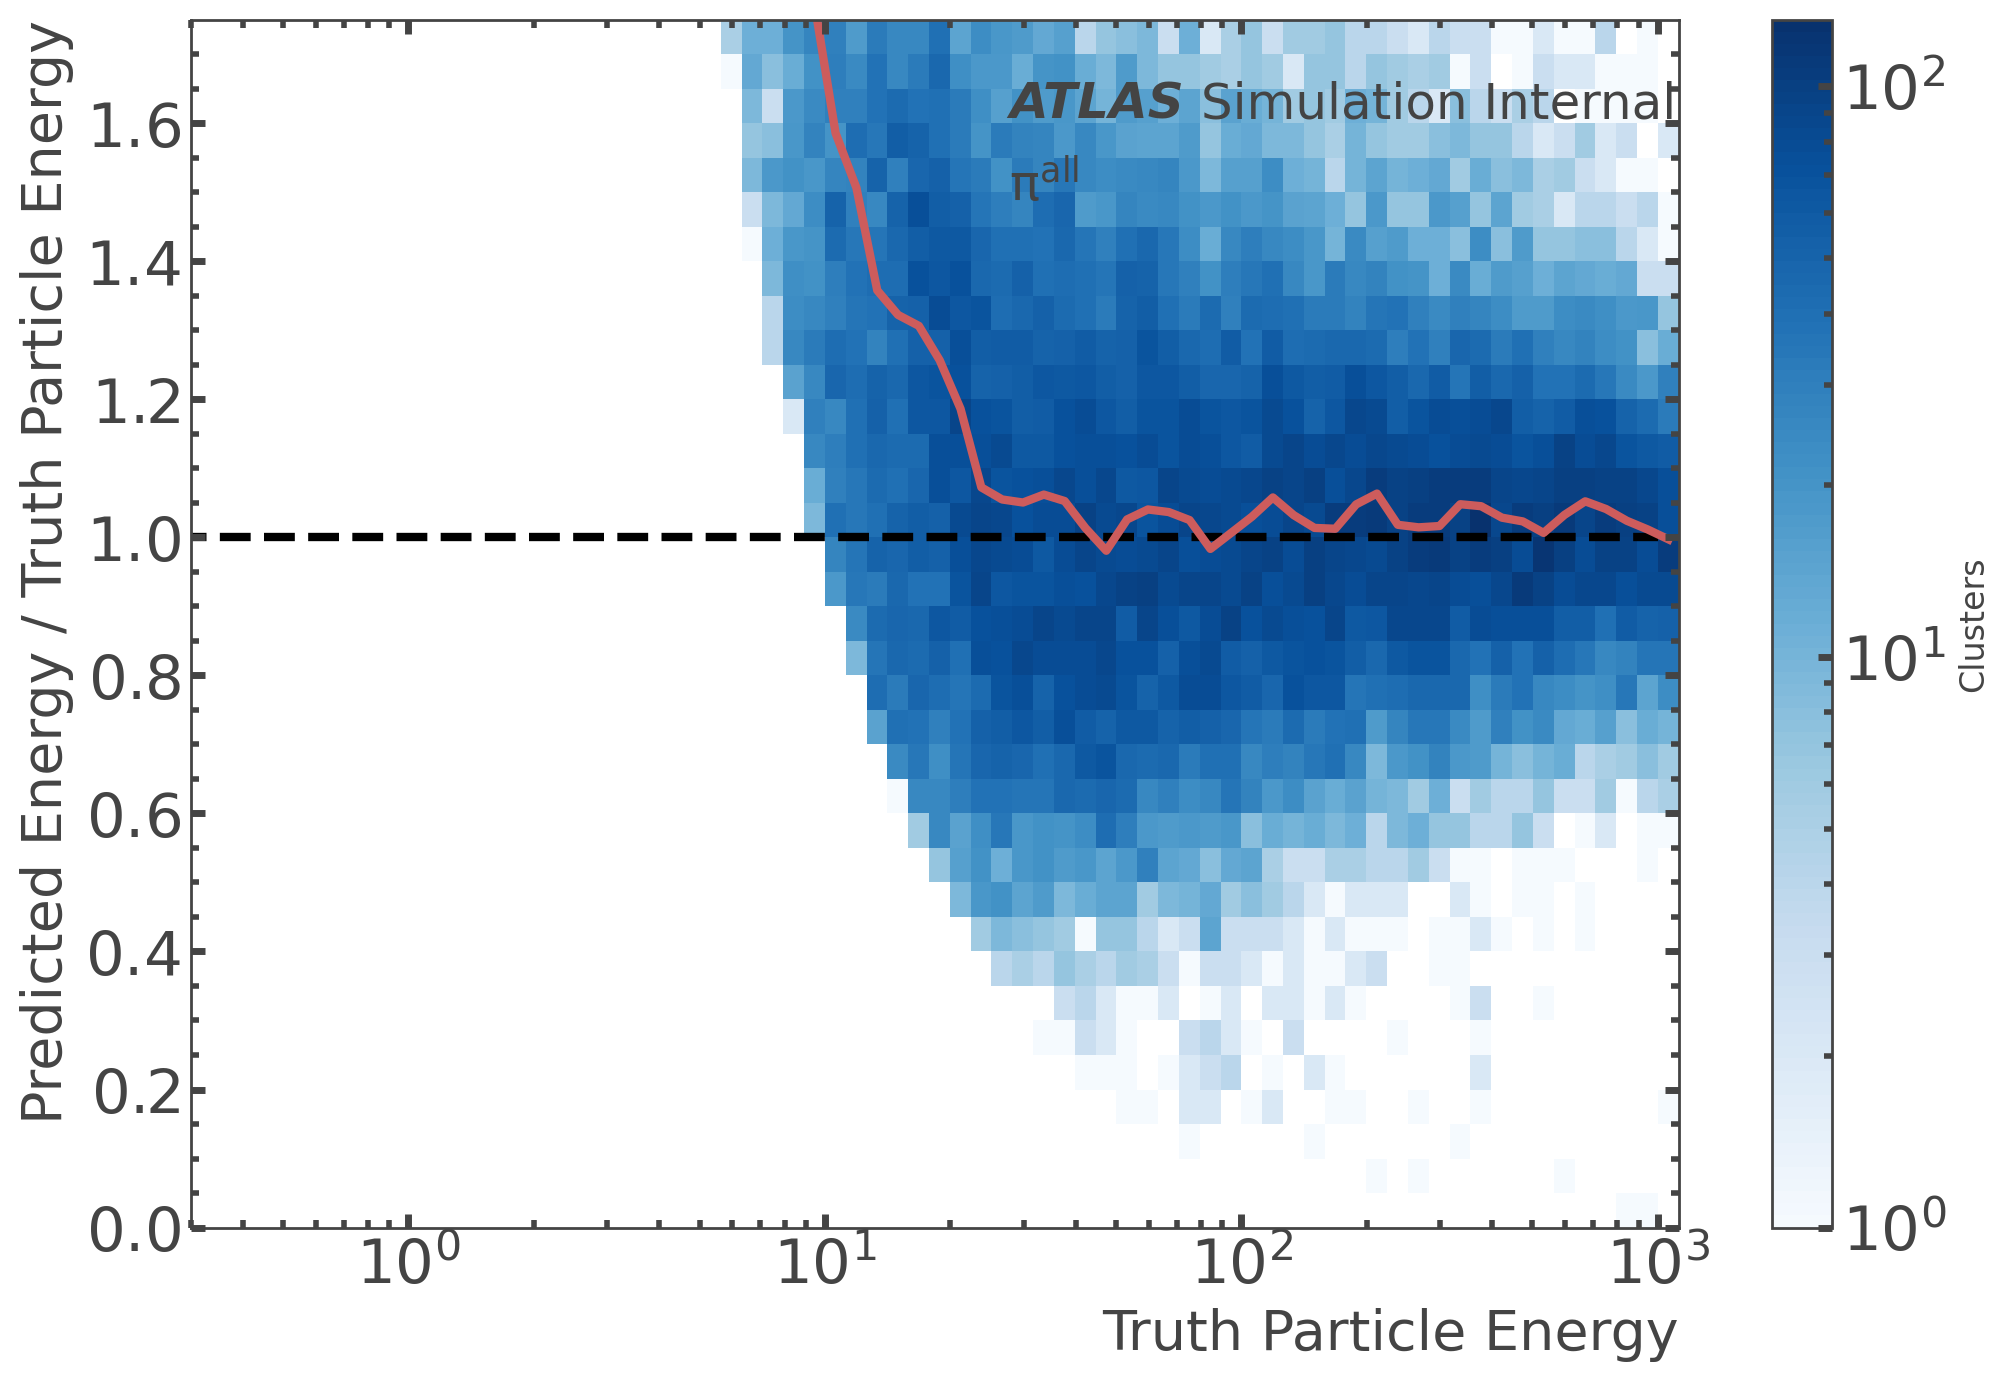

extra_line [[0, 10000.0], [1, 1]]


<Figure size 1600x1200 with 0 Axes>

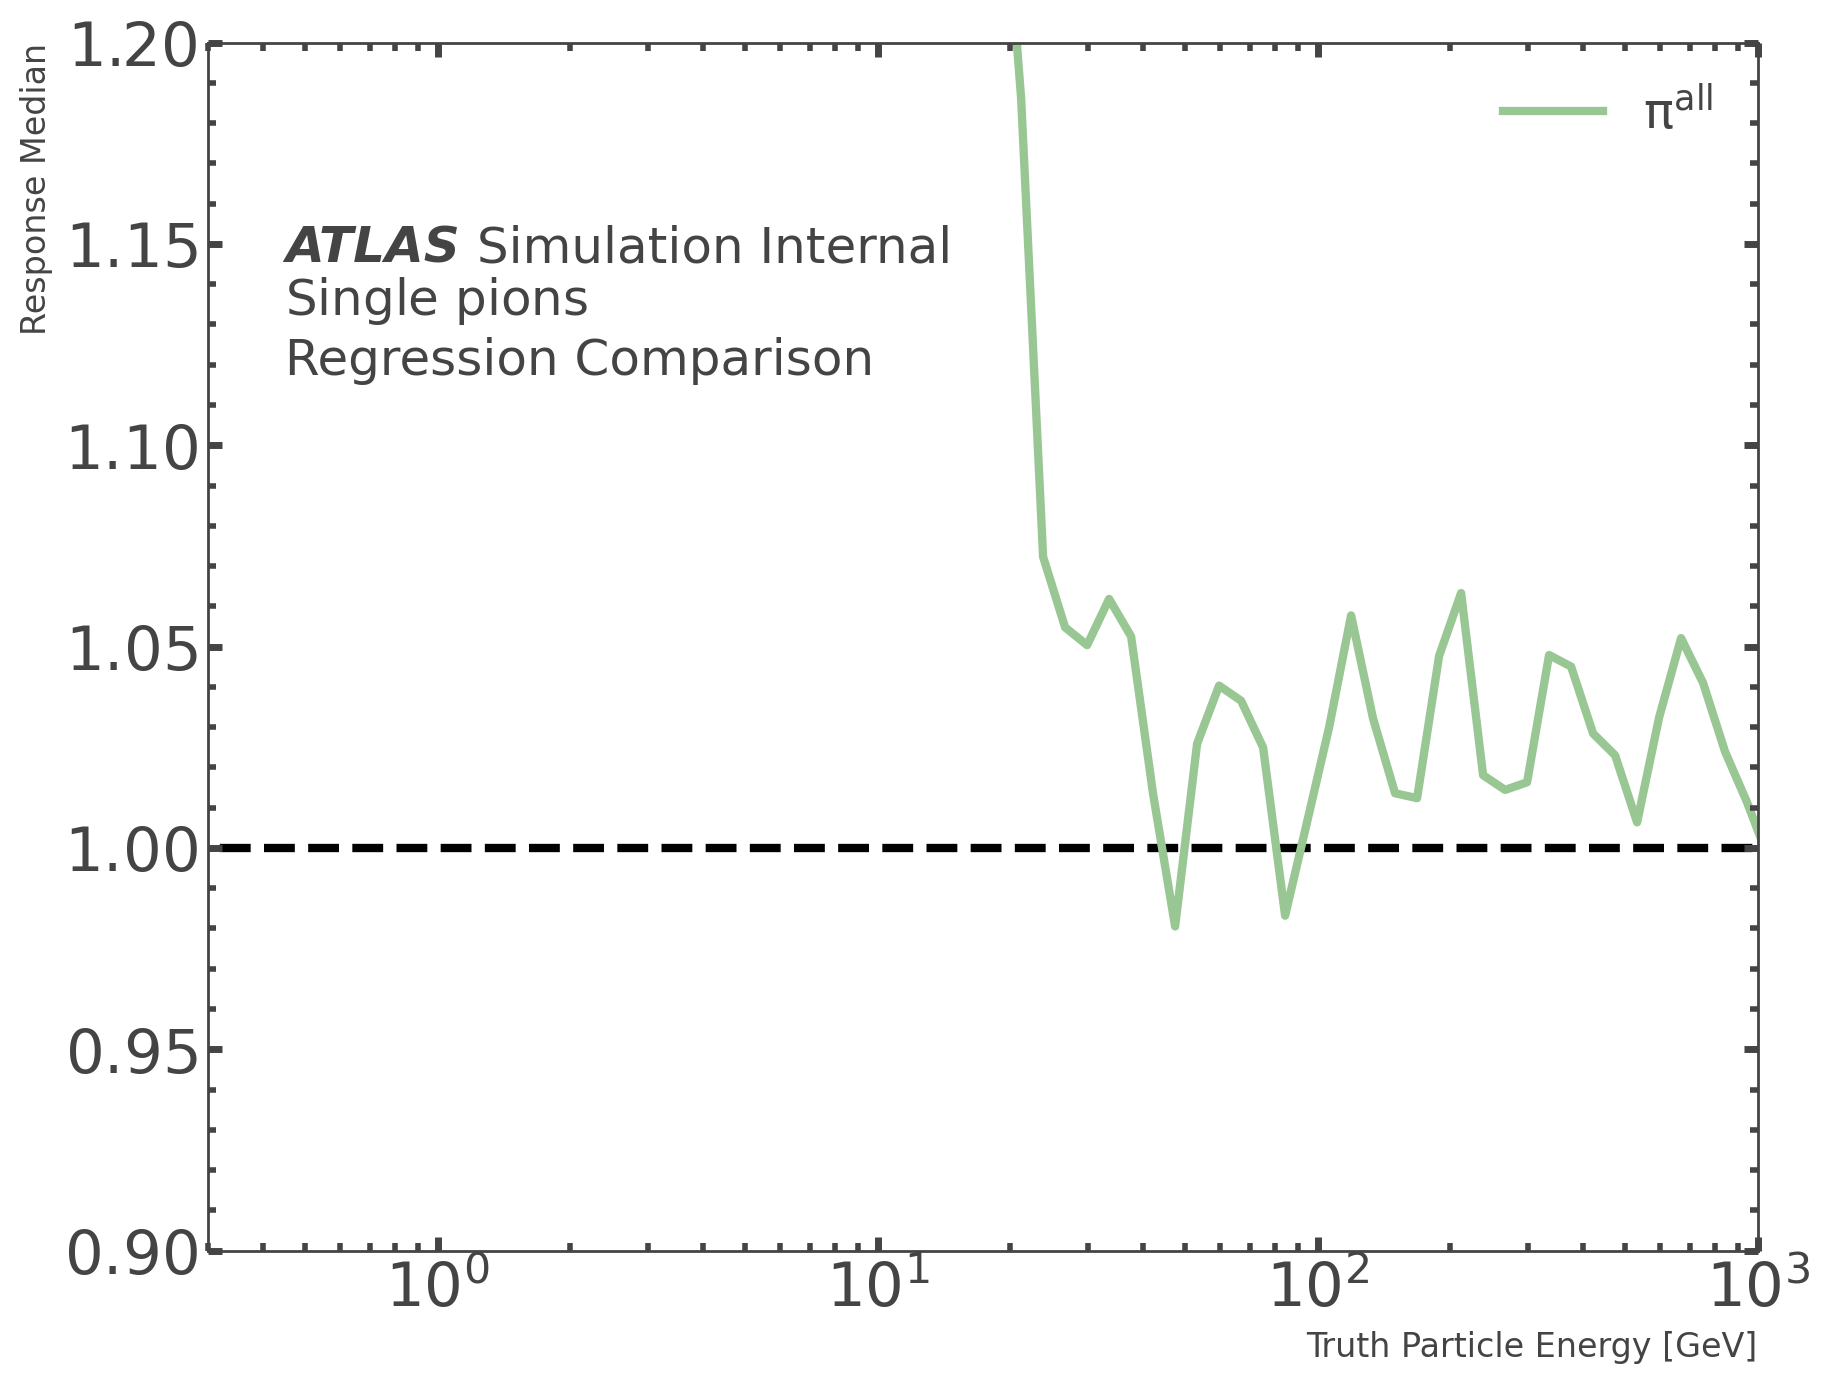


Plotting $\pi^{all}$


<Figure size 1600x1200 with 0 Axes>

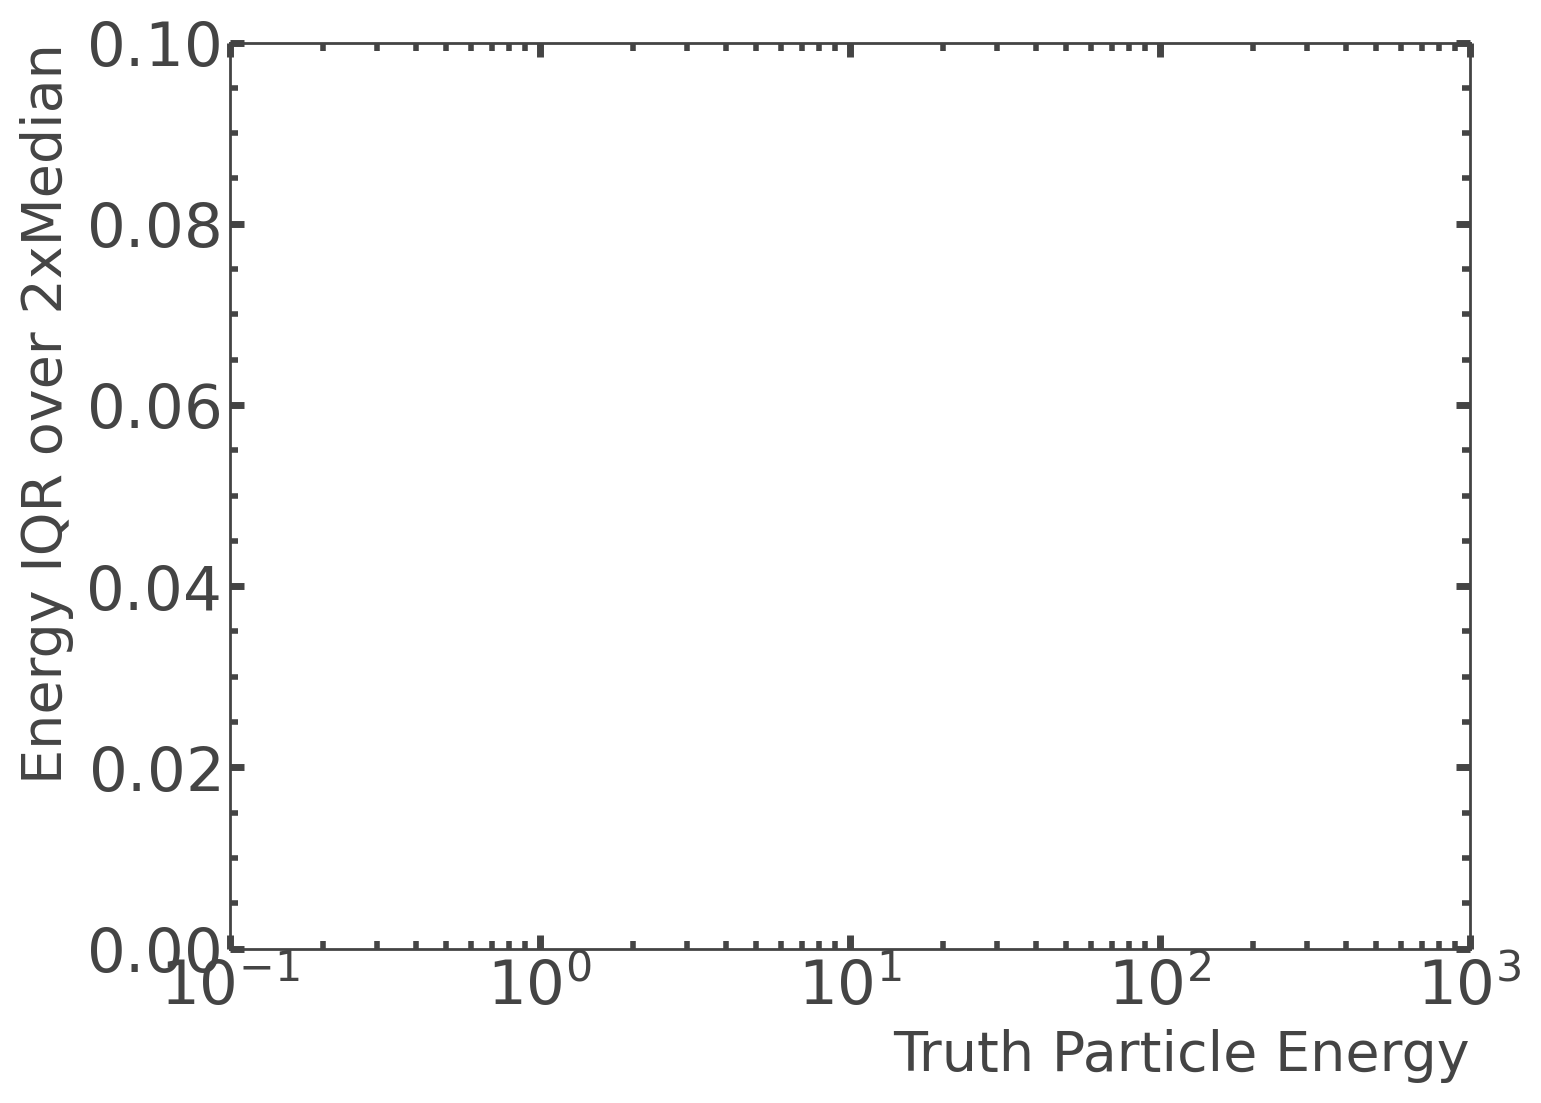

<Figure size 1600x1200 with 0 Axes>

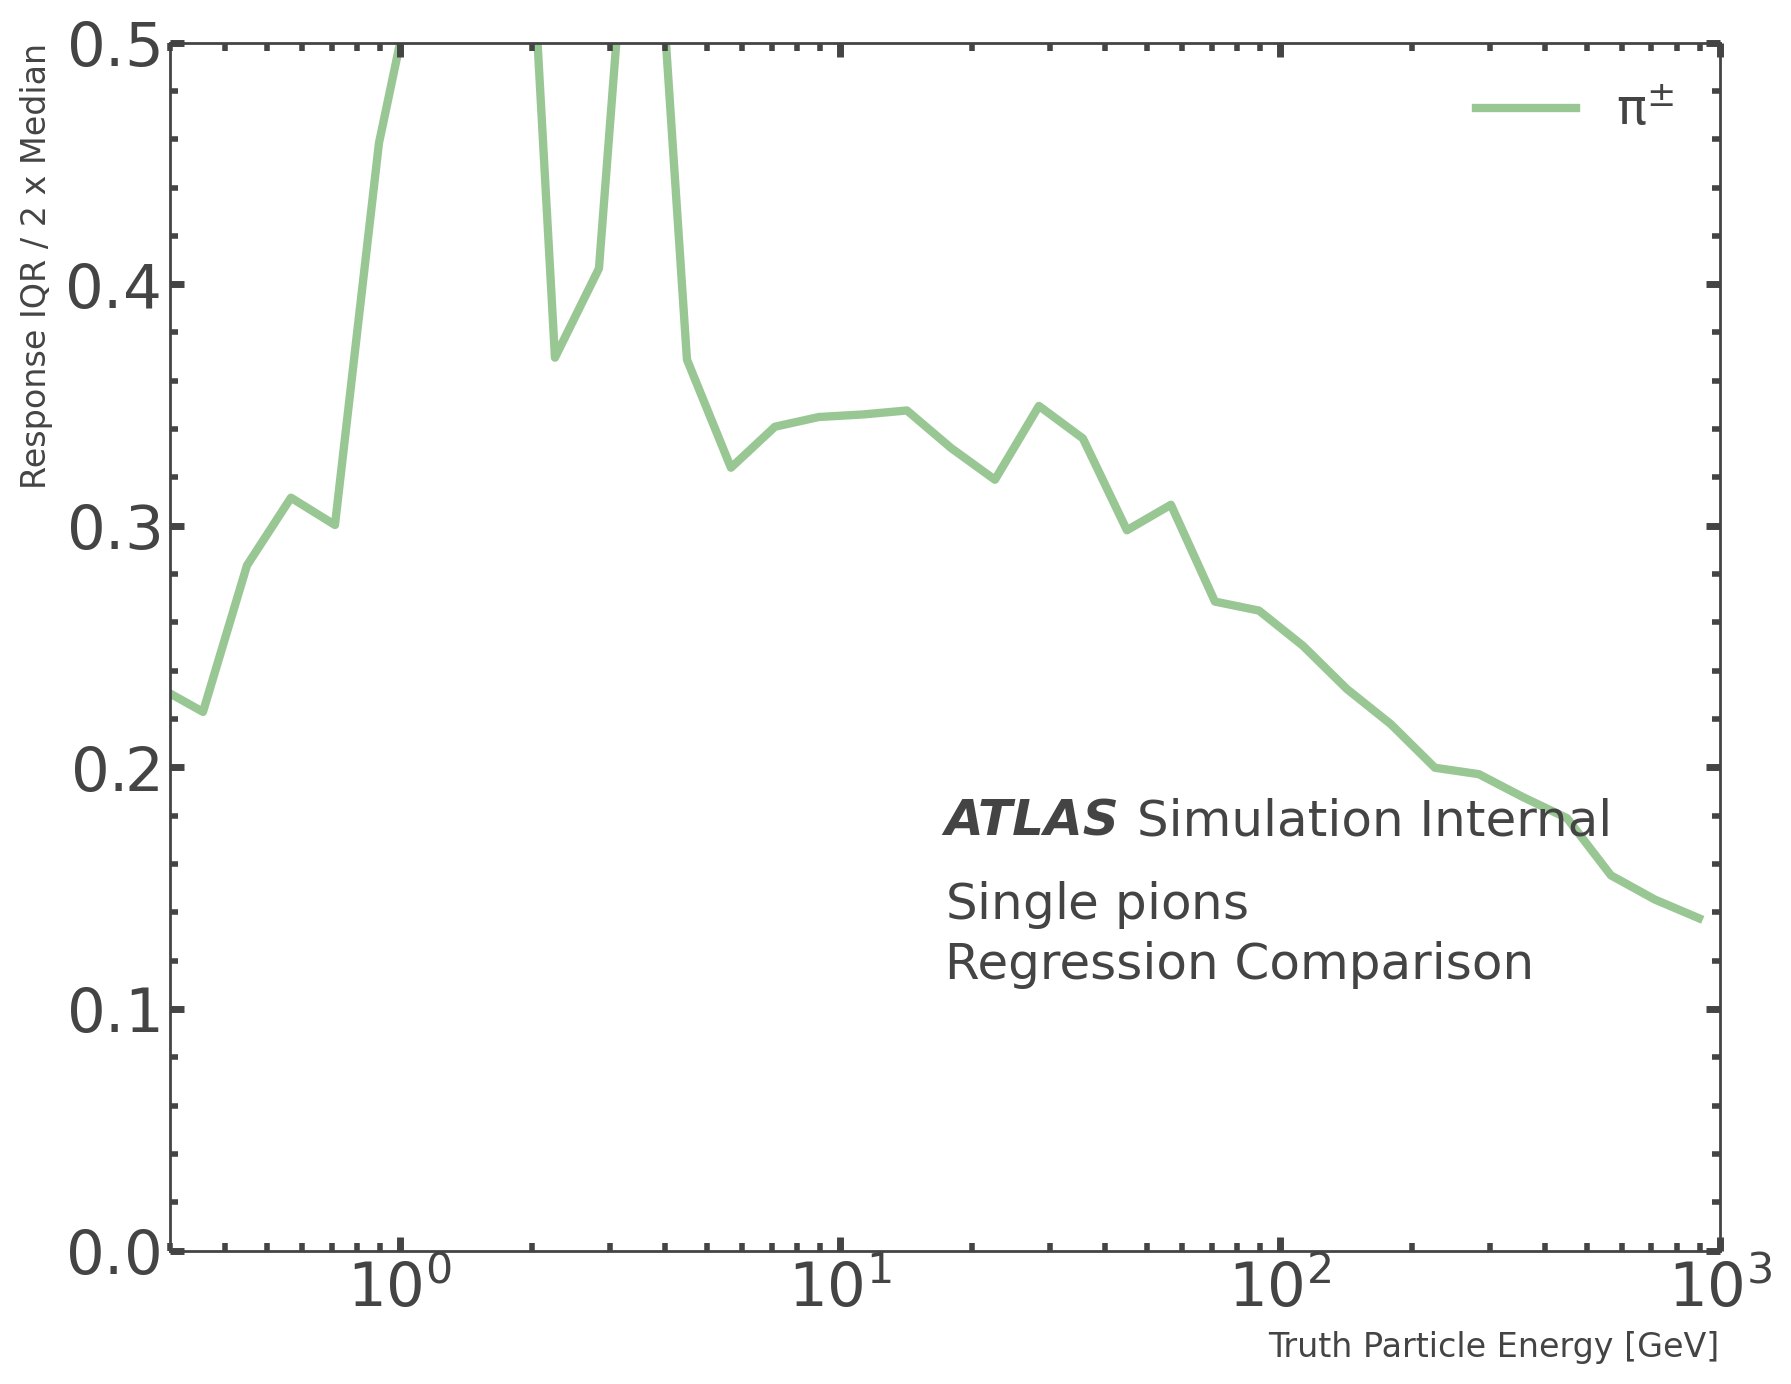

In [28]:
make_regression_plots(df_transformer, label="transformer", data_dir='./pub_note_results/')


Plotting $\pi^{all}$
r2:0.987
PearsonR:0.994, SpearmanR:0.980, MSE:896.795, MAE:10.545
Saving figure to results/onetrack_multicluster_hadweight/full_dataset_20220314//regress_em_all.png


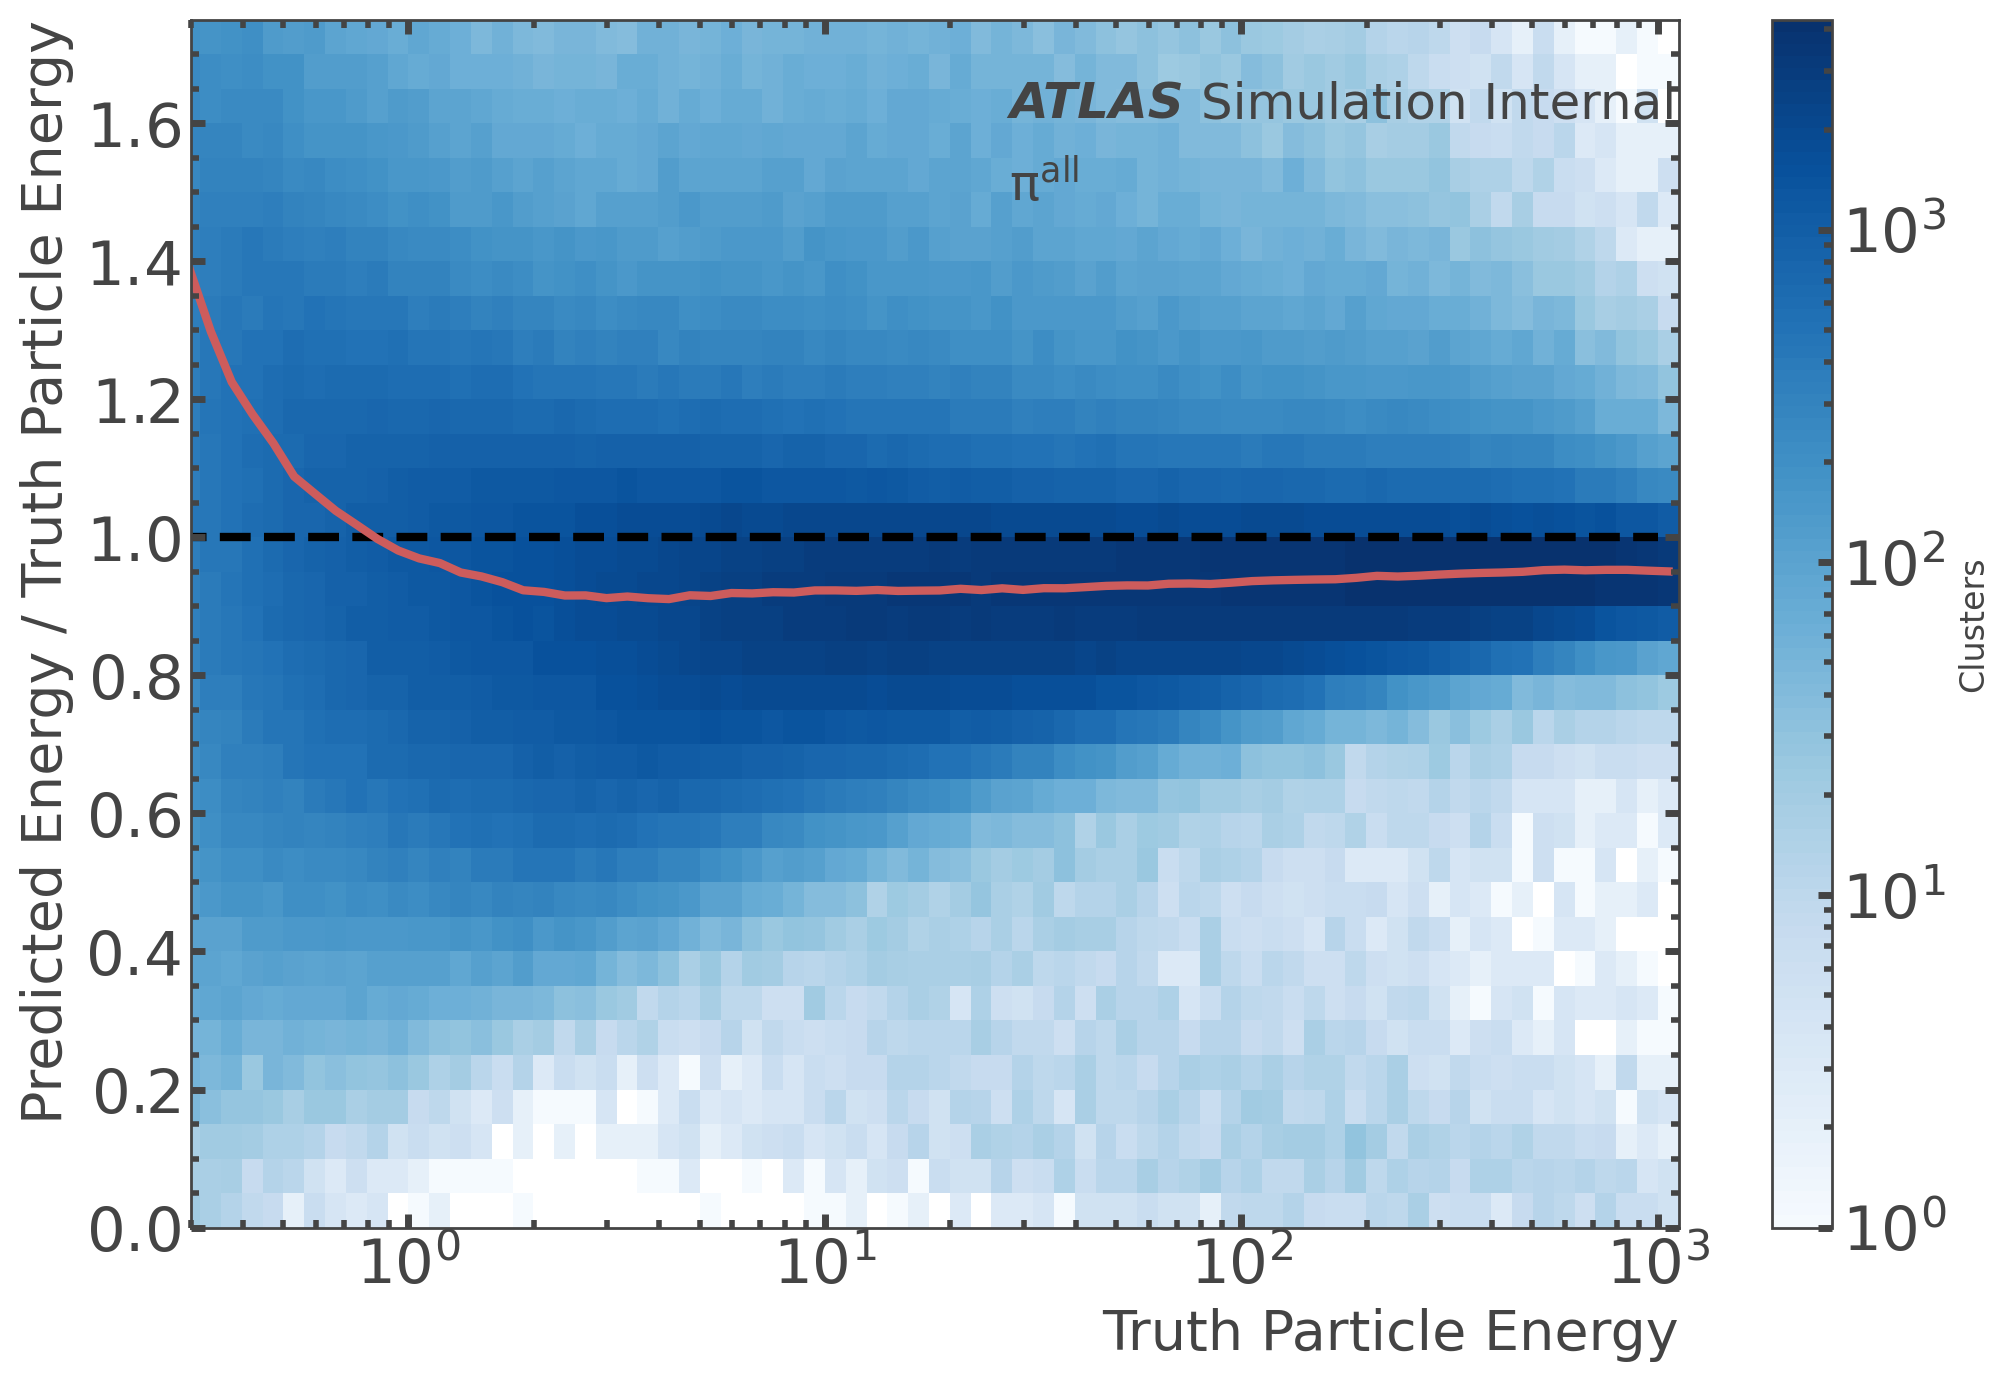


Plotting $\pi^{0}$
r2:0.994
PearsonR:0.997, SpearmanR:0.955, MSE:750.331, MAE:9.071
Saving figure to results/onetrack_multicluster_hadweight/full_dataset_20220314//regress_em_pi0.png


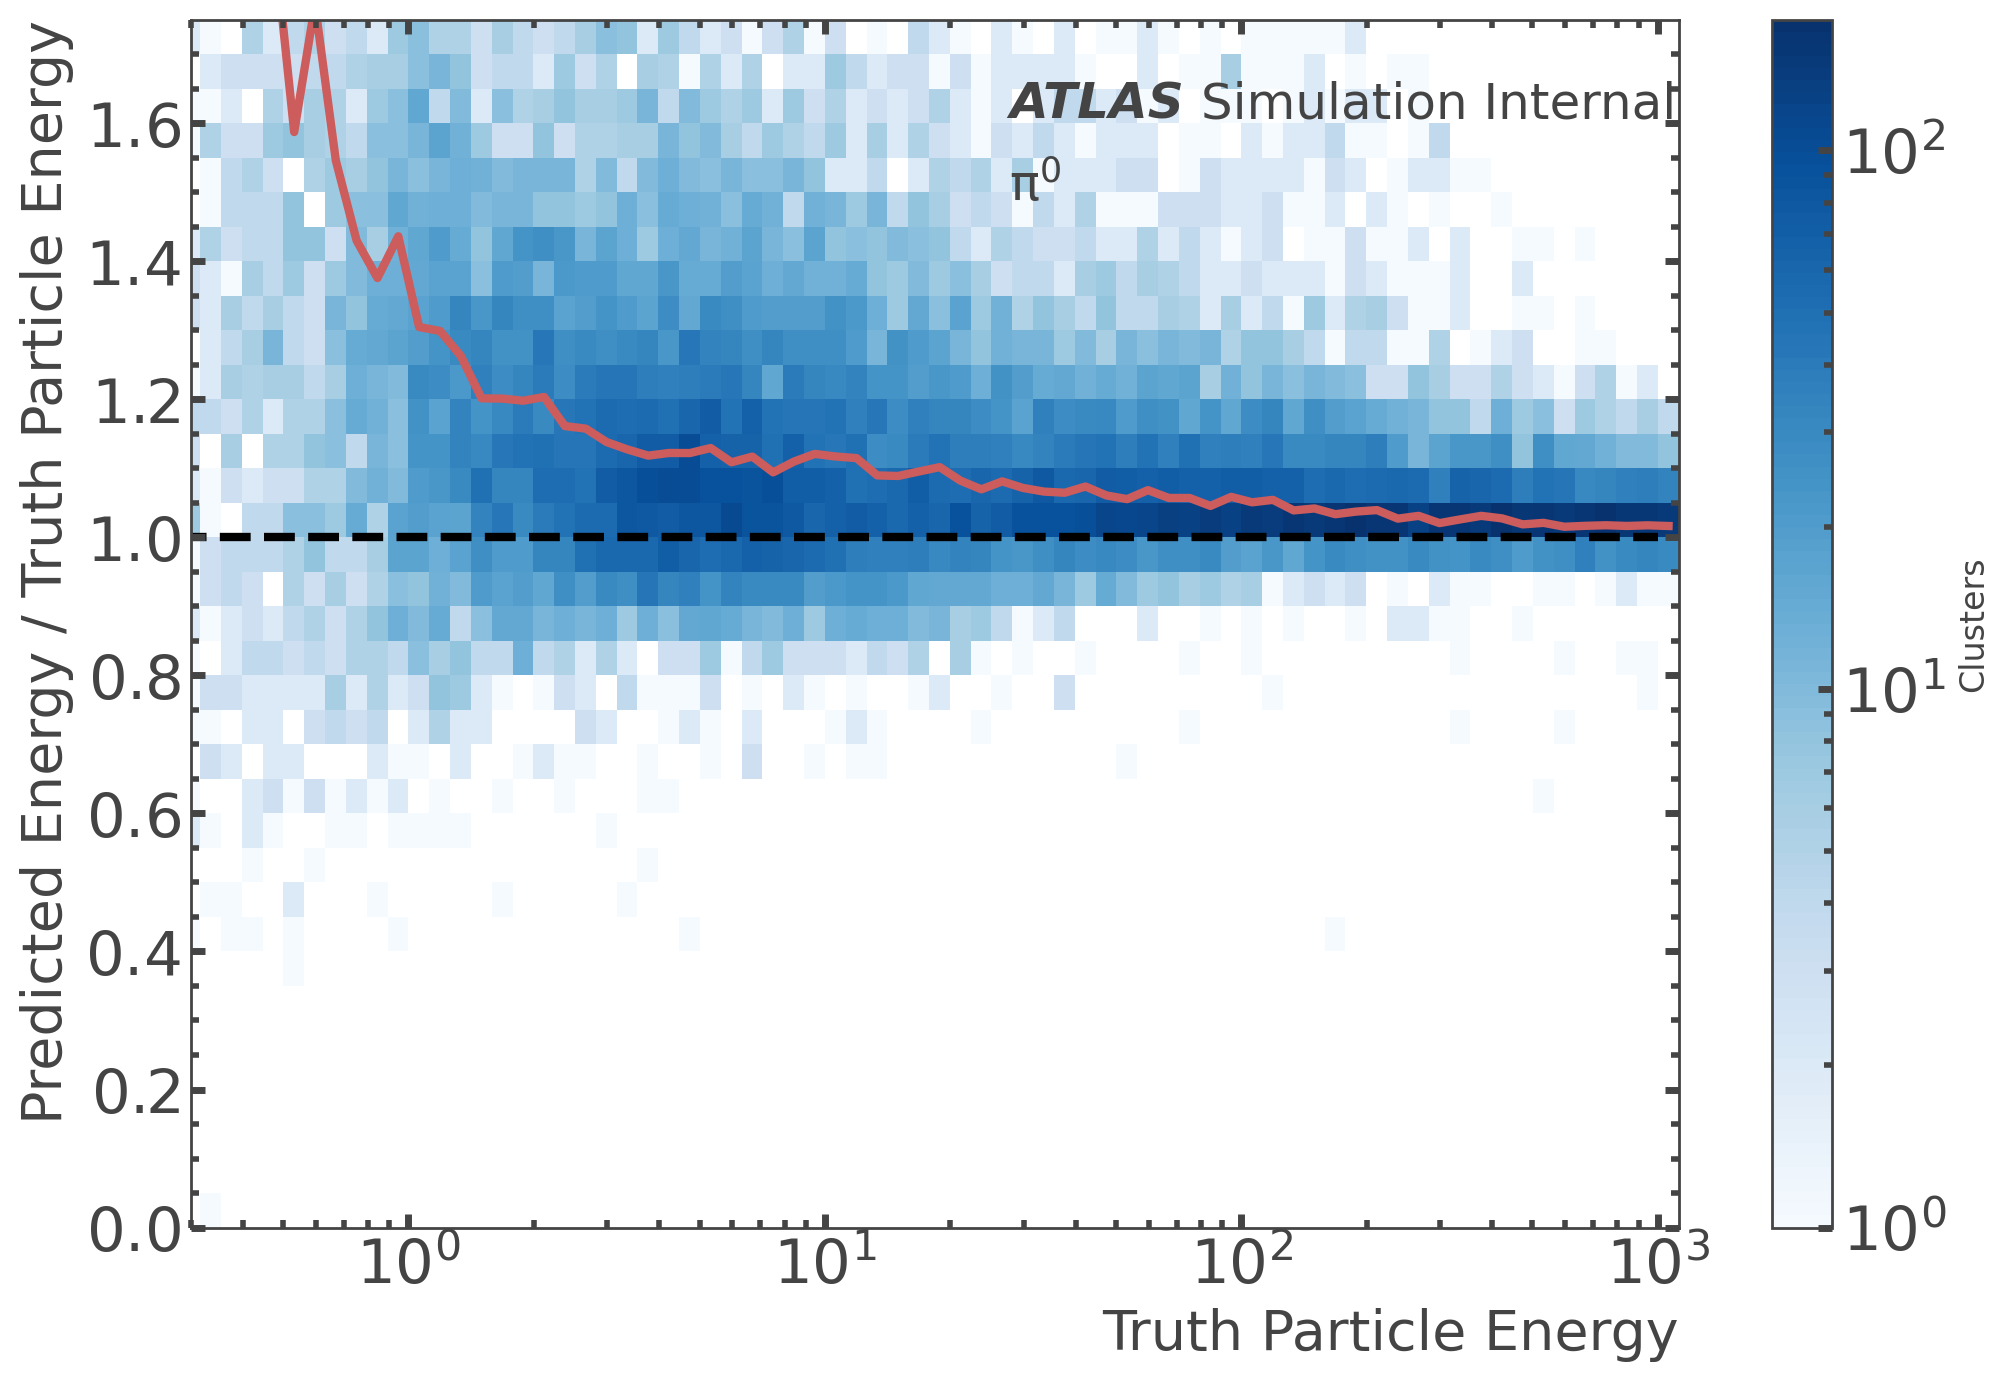


Plotting $\pi^{\pm}$
r2:0.987
PearsonR:0.994, SpearmanR:0.981, MSE:899.858, MAE:10.576
Saving figure to results/onetrack_multicluster_hadweight/full_dataset_20220314//regress_em_pion.png


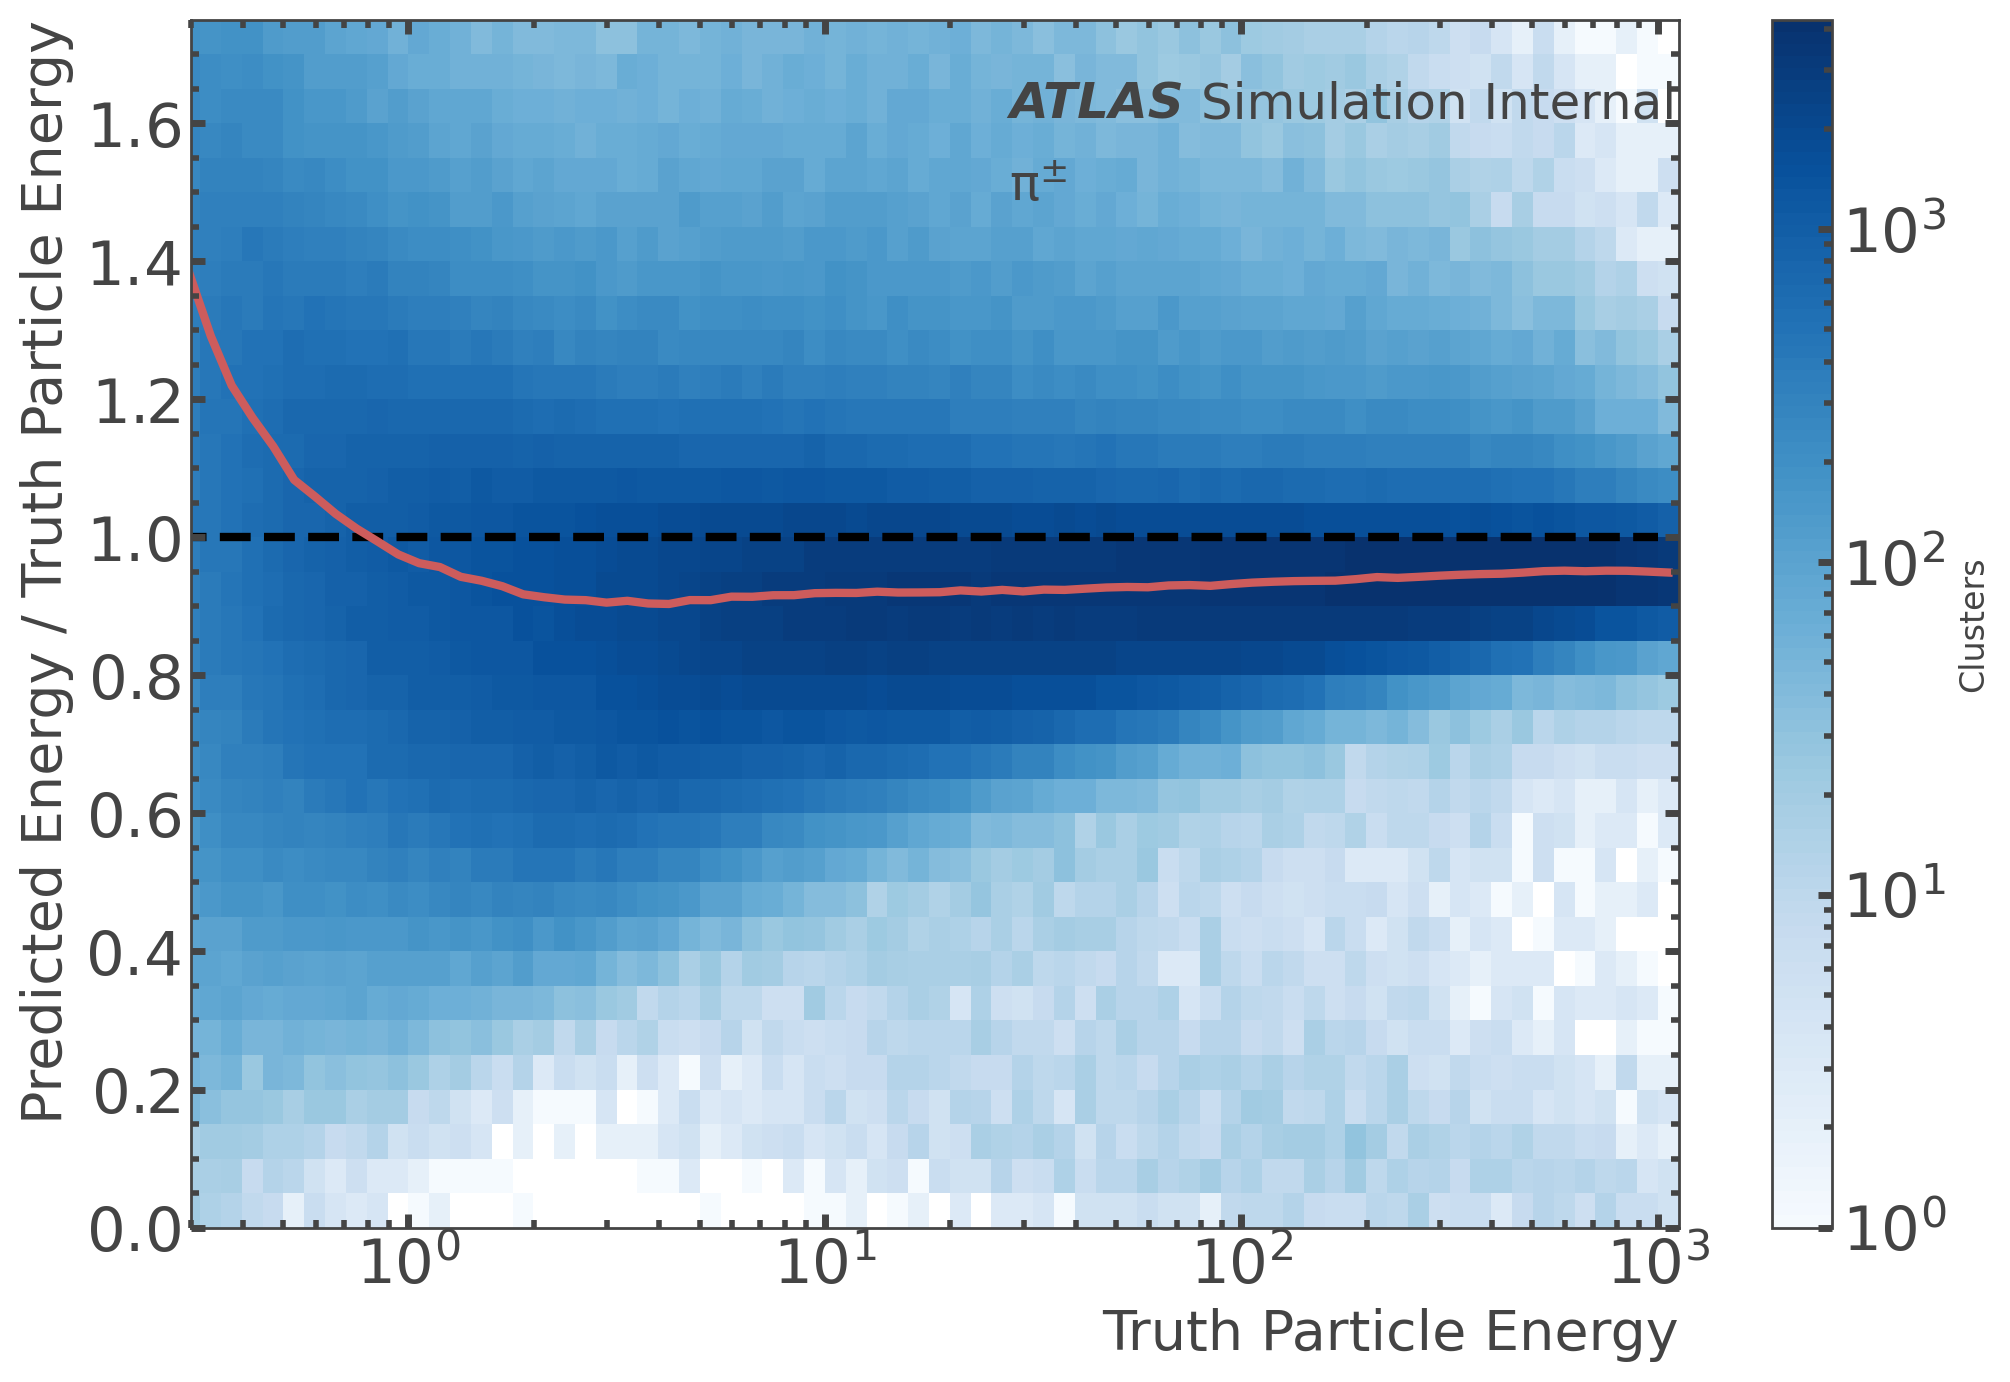


Plotting $\pi^{all}$


<Figure size 1600x1200 with 0 Axes>

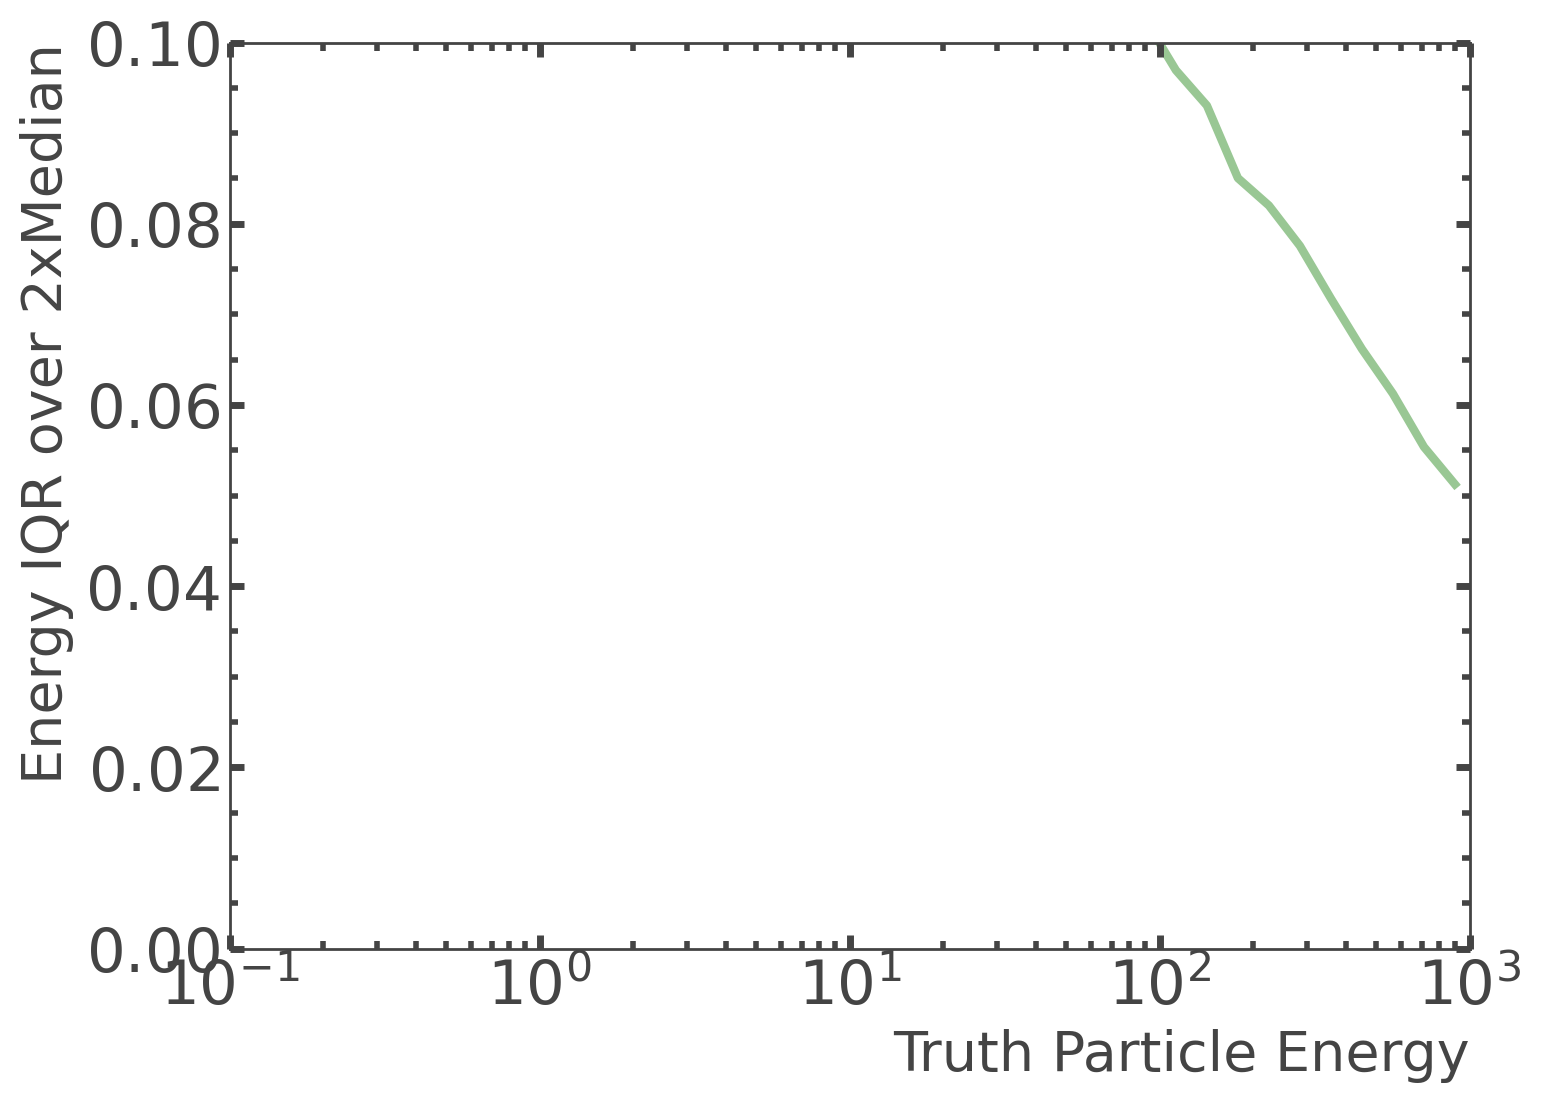


Plotting $\pi^{0}$


<Figure size 1600x1200 with 0 Axes>

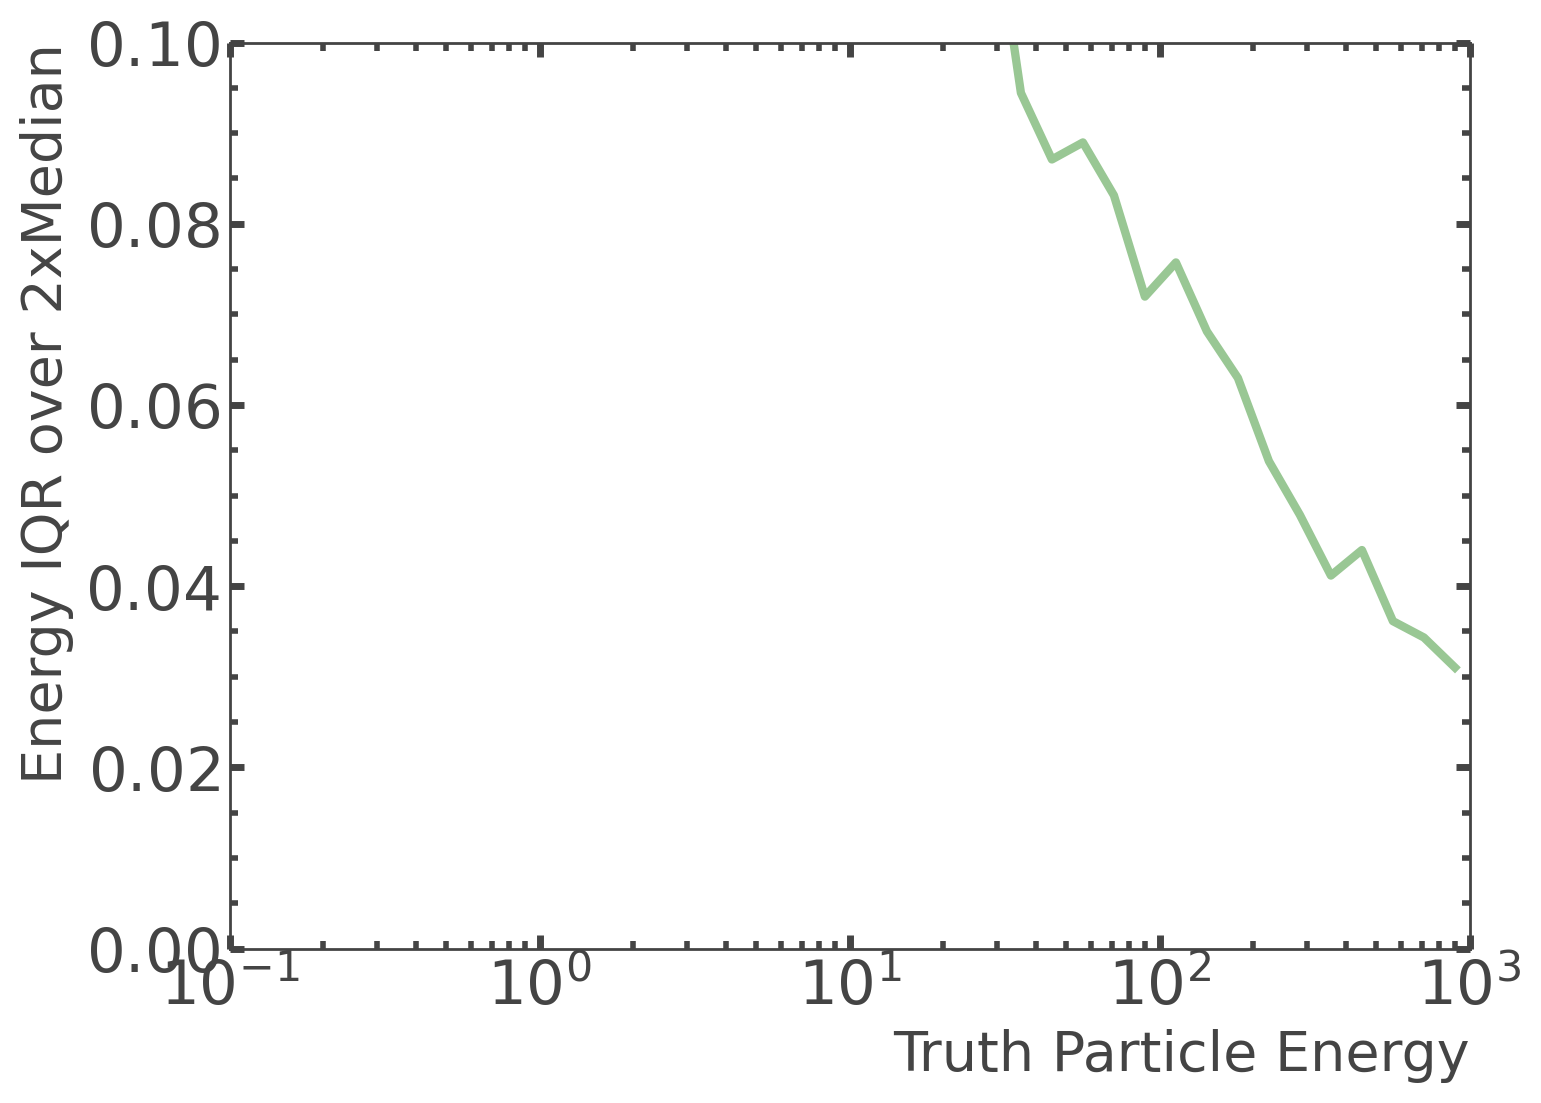


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

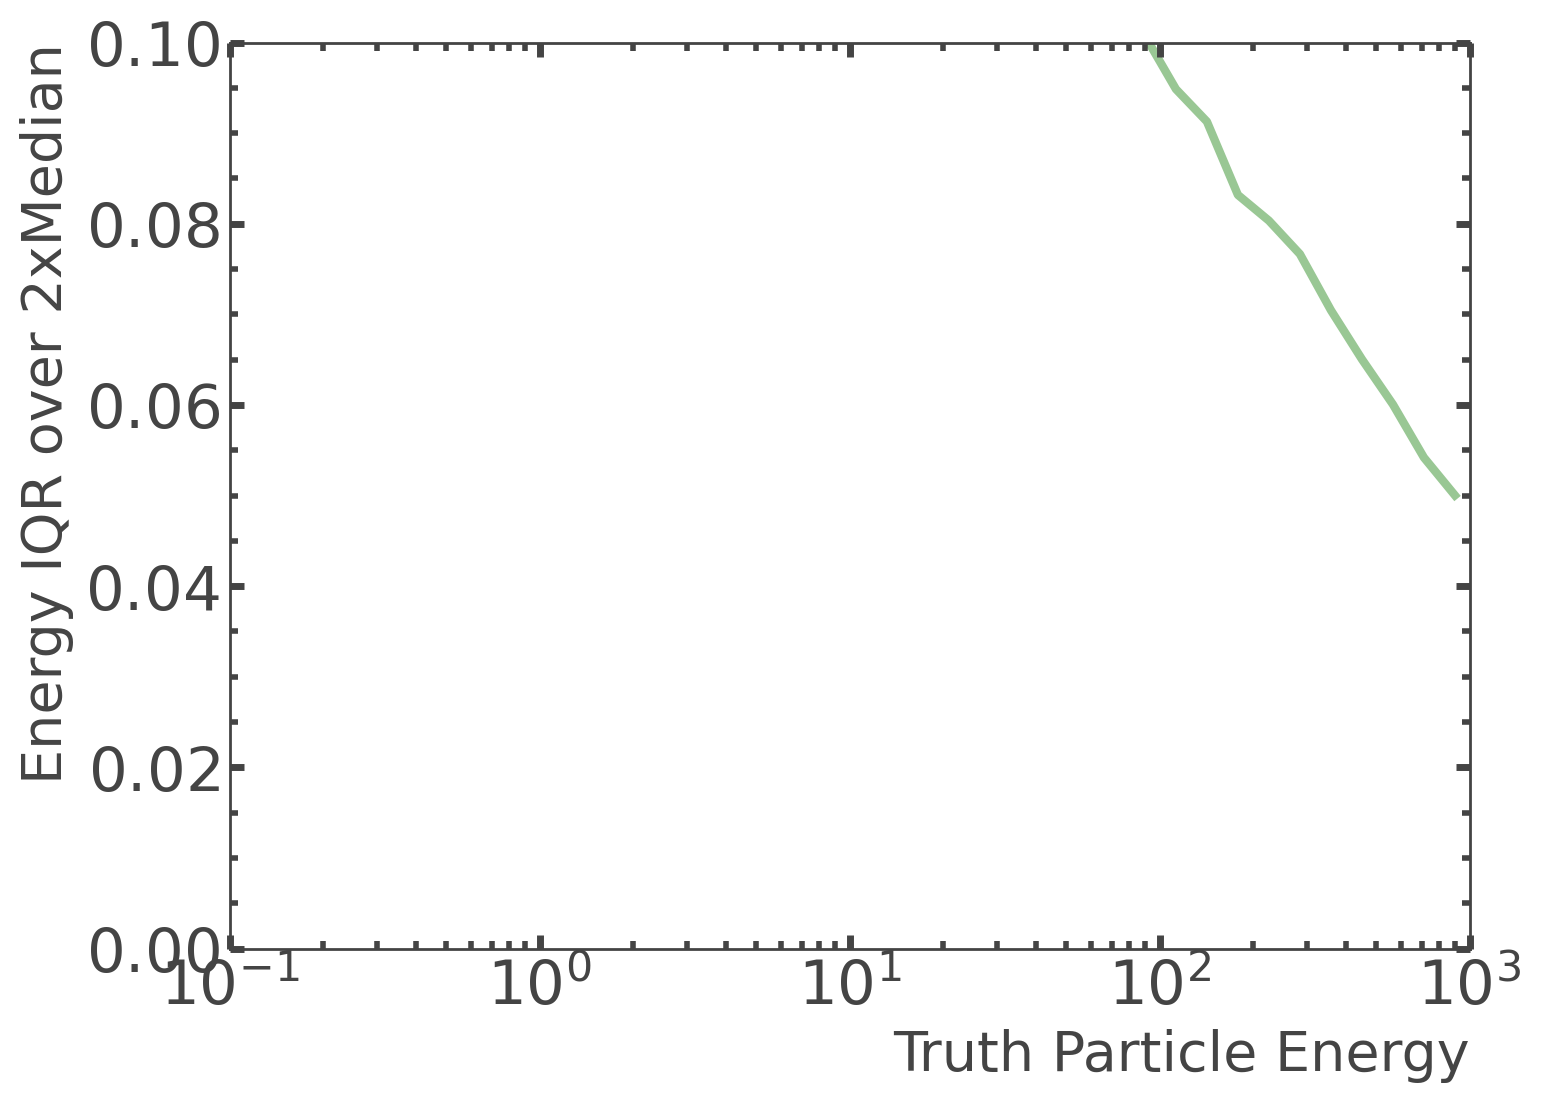

<Figure size 1600x1200 with 0 Axes>

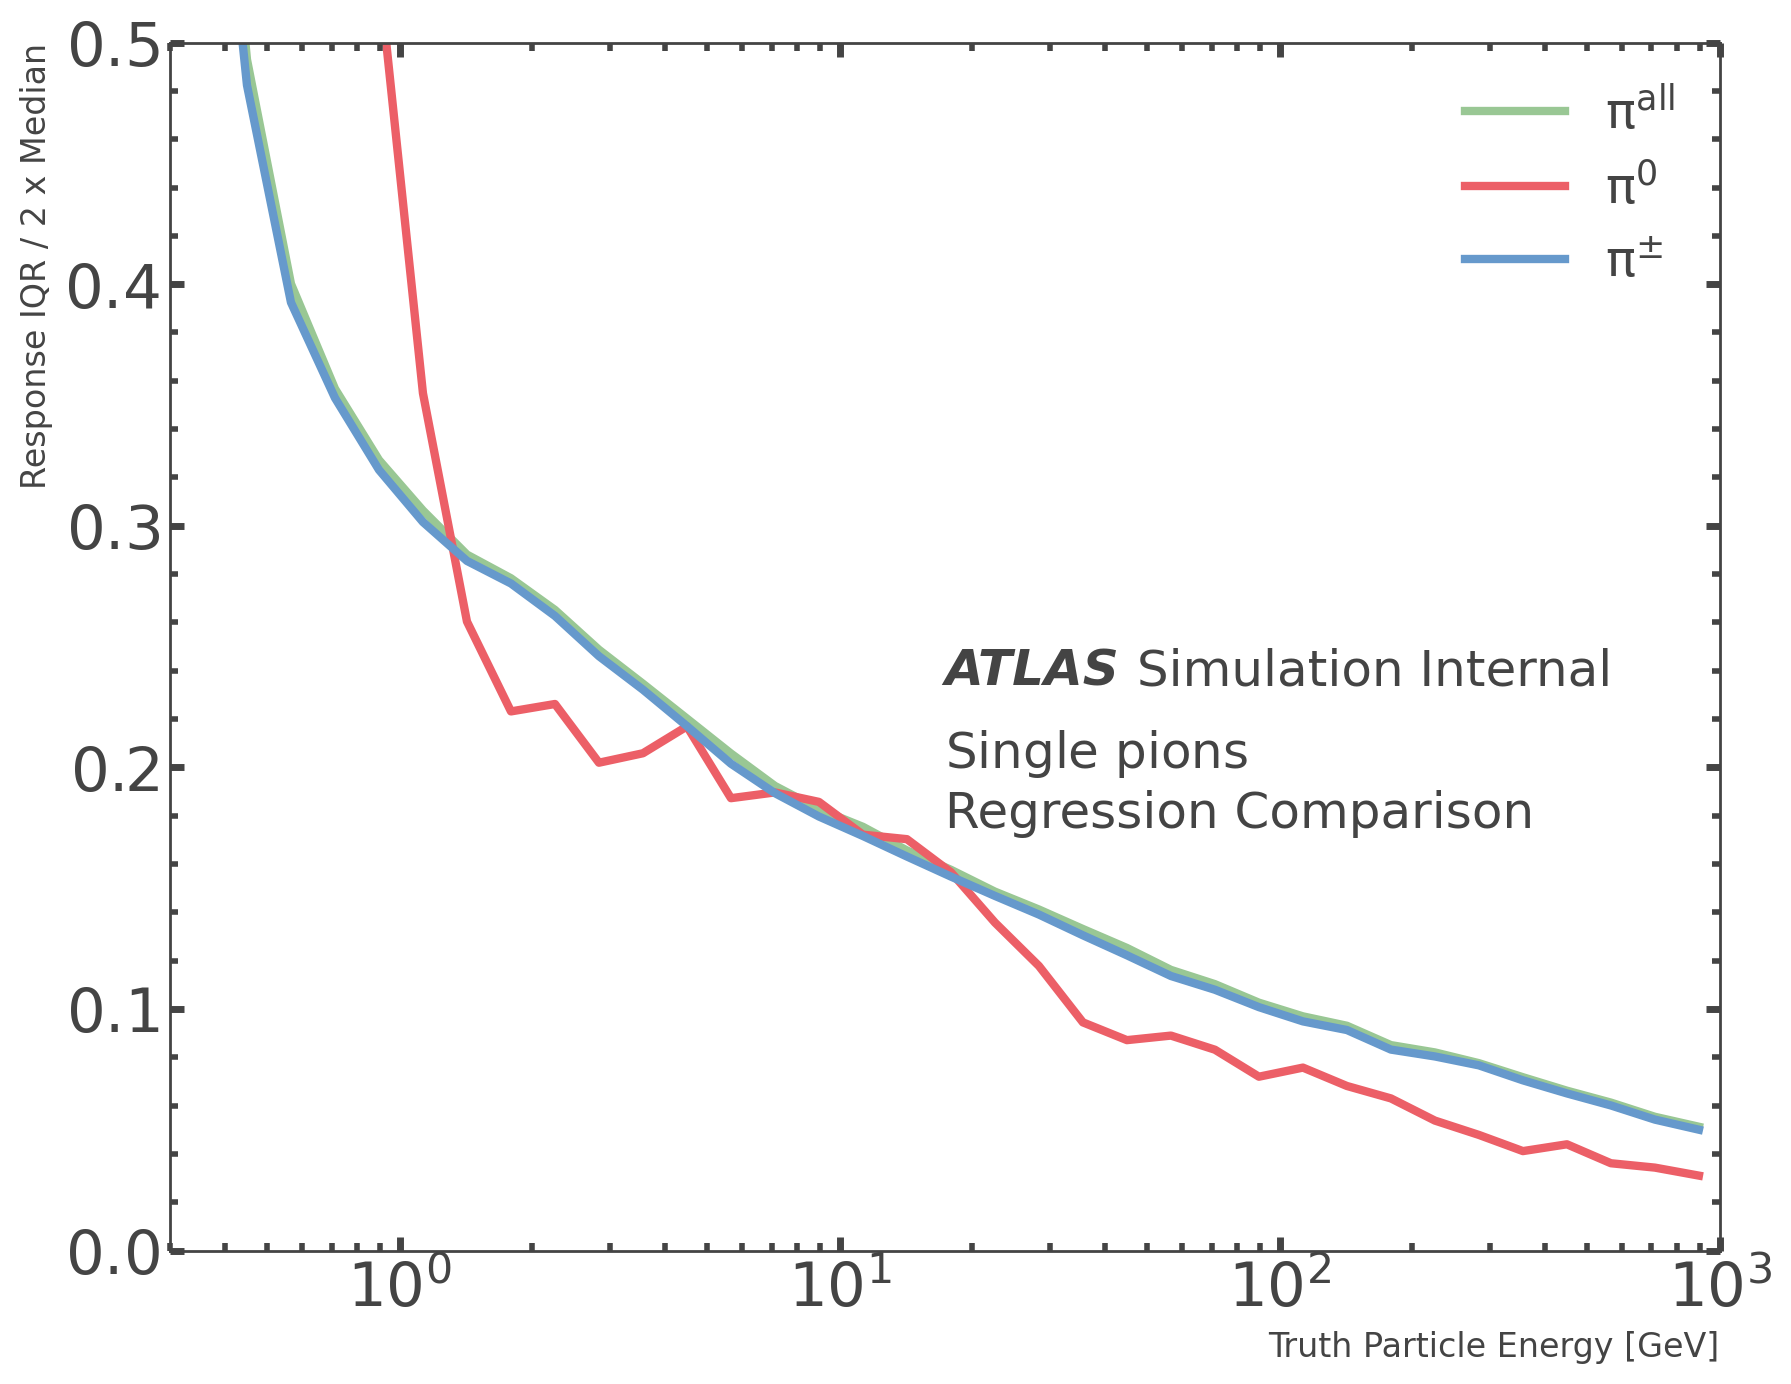


Plotting $\pi^{all}$
r2:0.989
PearsonR:0.995, SpearmanR:0.982, MSE:748.445, MAE:7.674
Saving figure to results/onetrack_multicluster_hadweight/full_dataset_20220314//regress_lcw_all.png


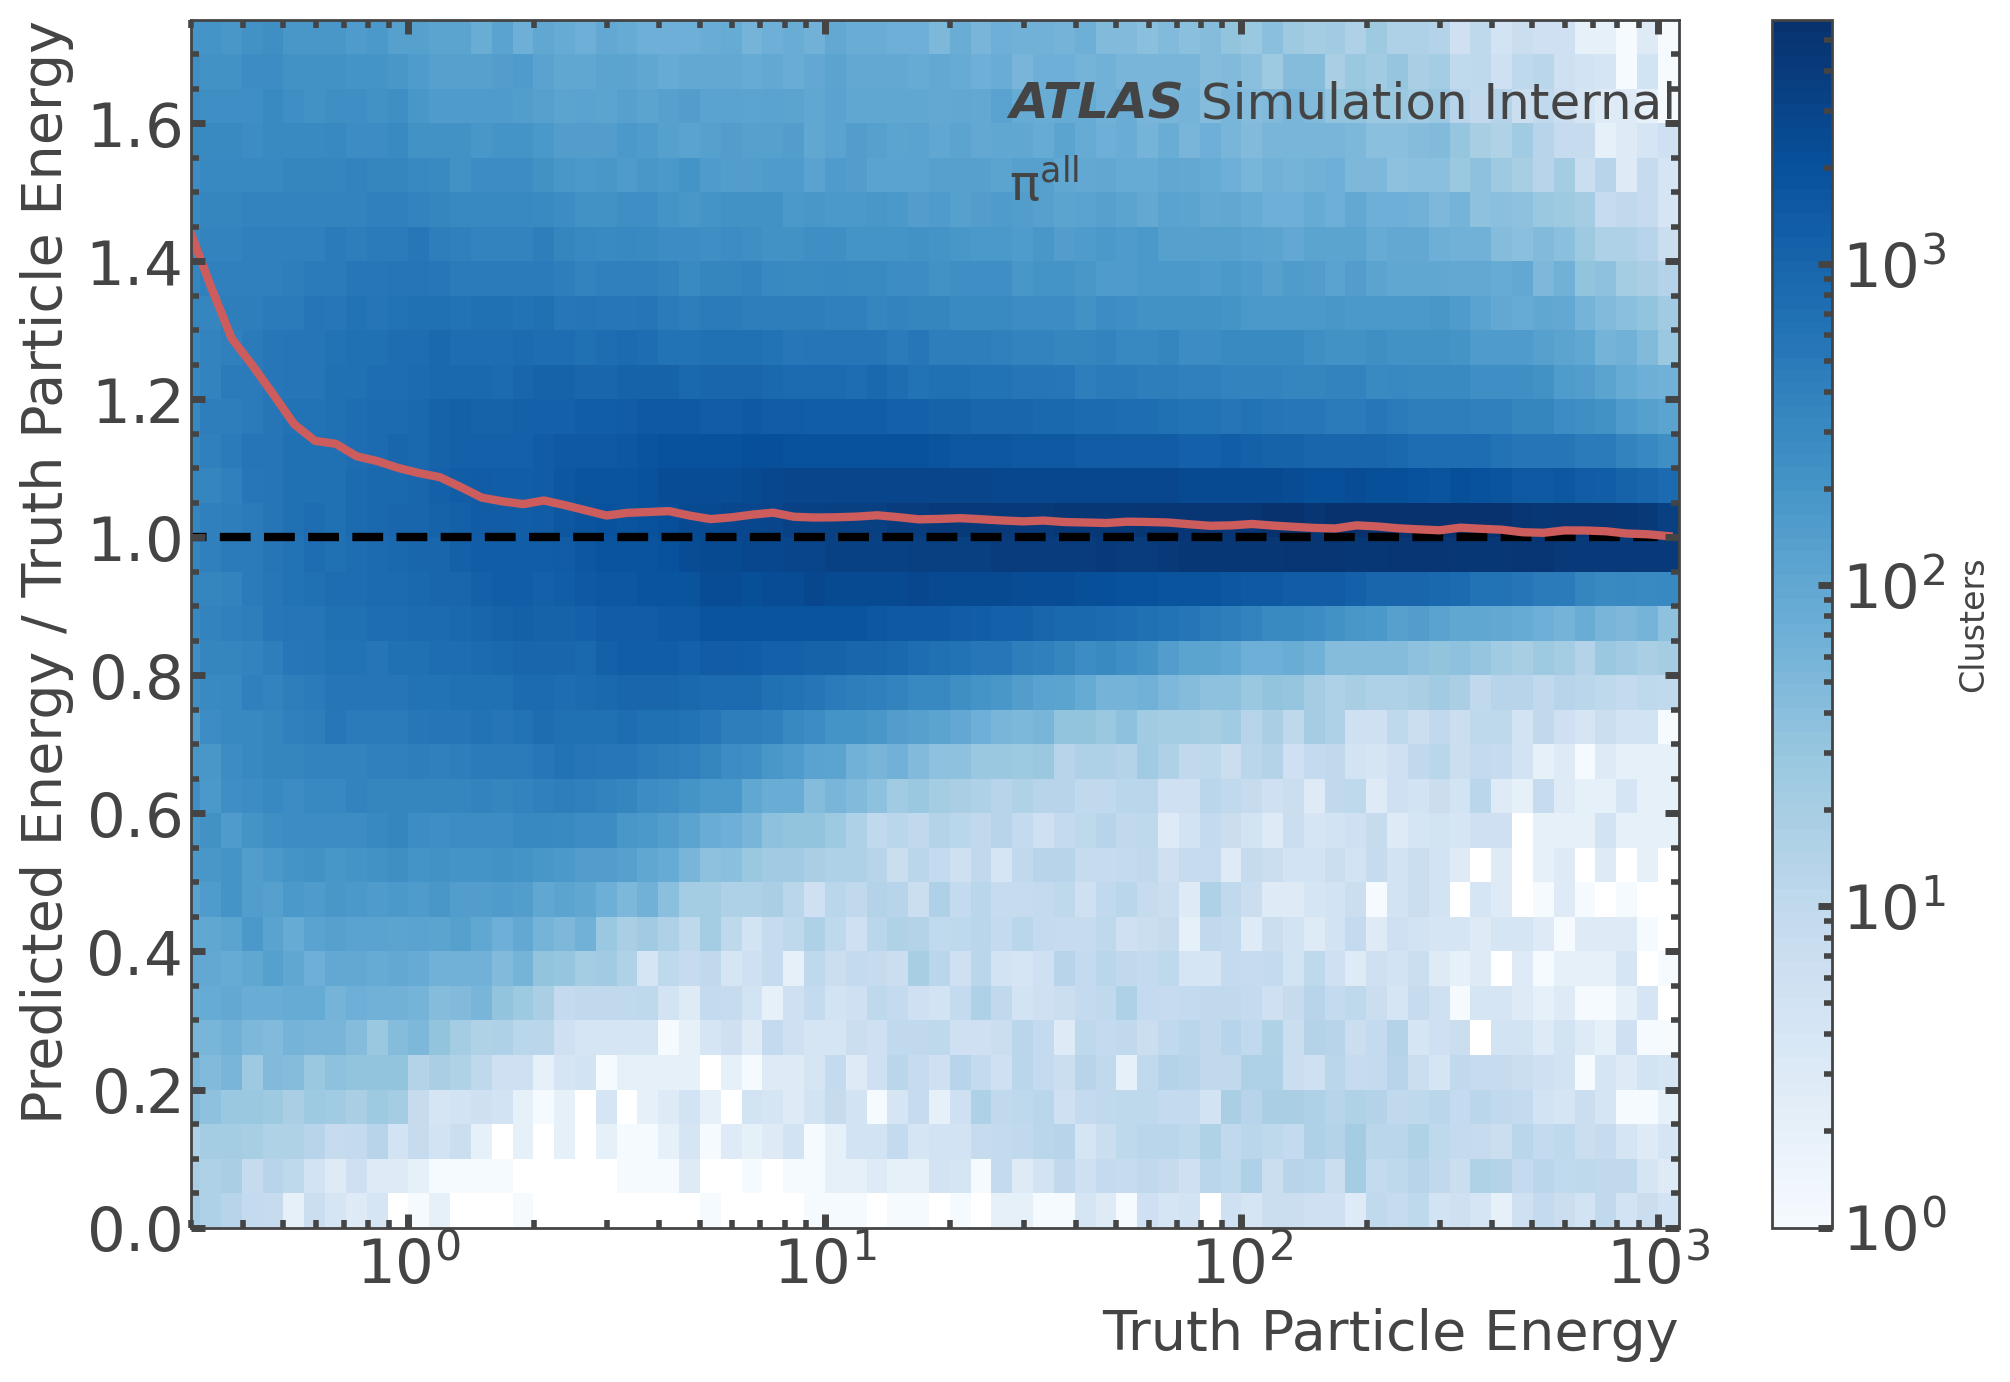


Plotting $\pi^{0}$
r2:0.993
PearsonR:0.997, SpearmanR:0.956, MSE:785.146, MAE:9.706
Saving figure to results/onetrack_multicluster_hadweight/full_dataset_20220314//regress_lcw_pi0.png


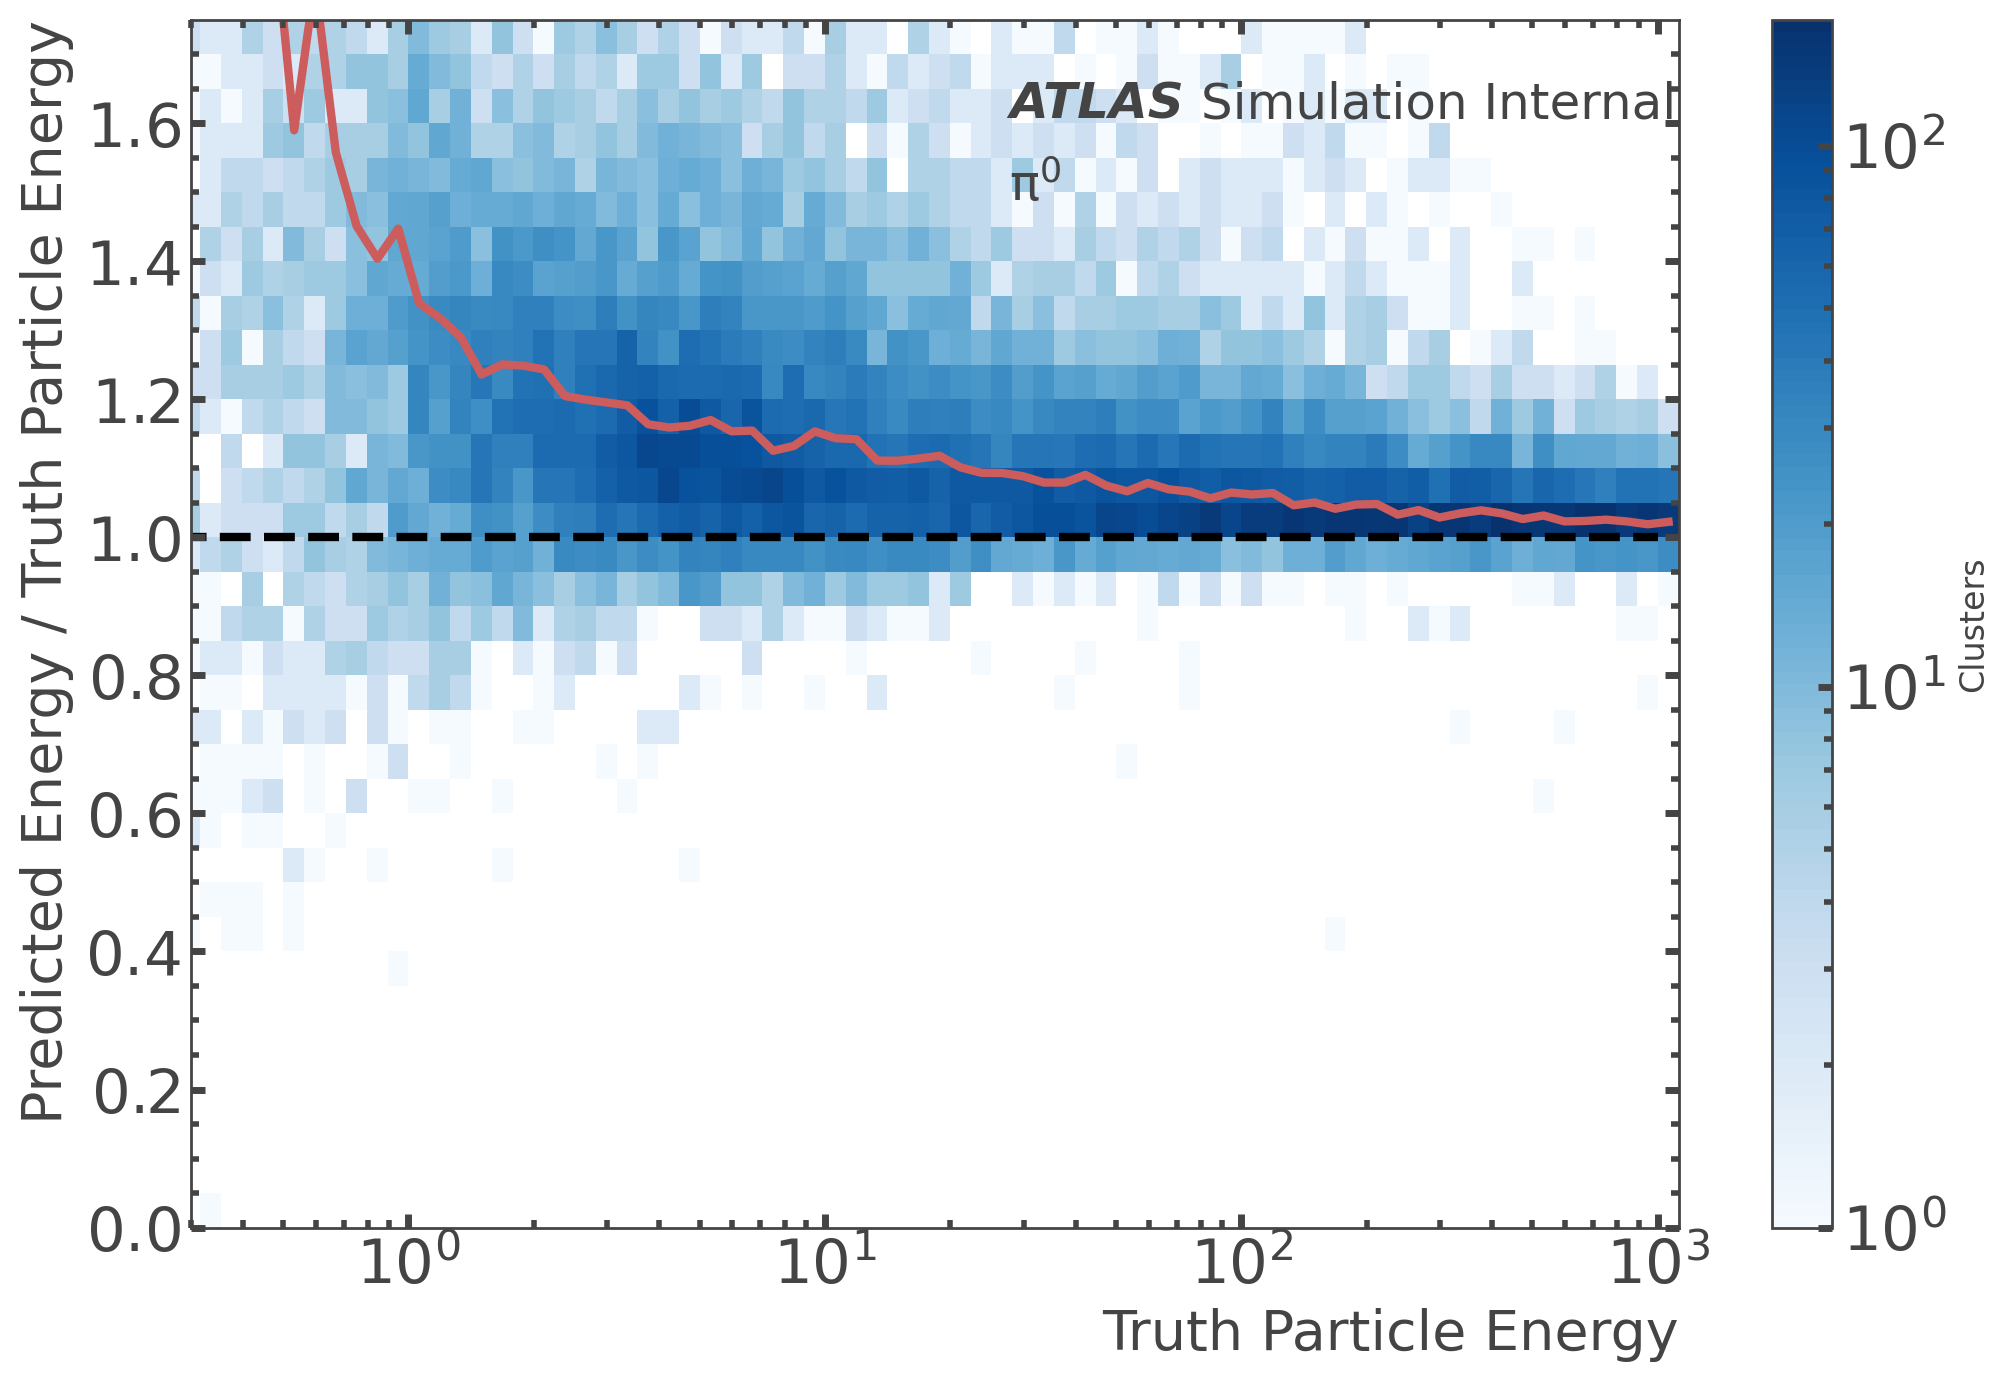


Plotting $\pi^{\pm}$
r2:0.989
PearsonR:0.995, SpearmanR:0.983, MSE:747.677, MAE:7.631
Saving figure to results/onetrack_multicluster_hadweight/full_dataset_20220314//regress_lcw_pion.png


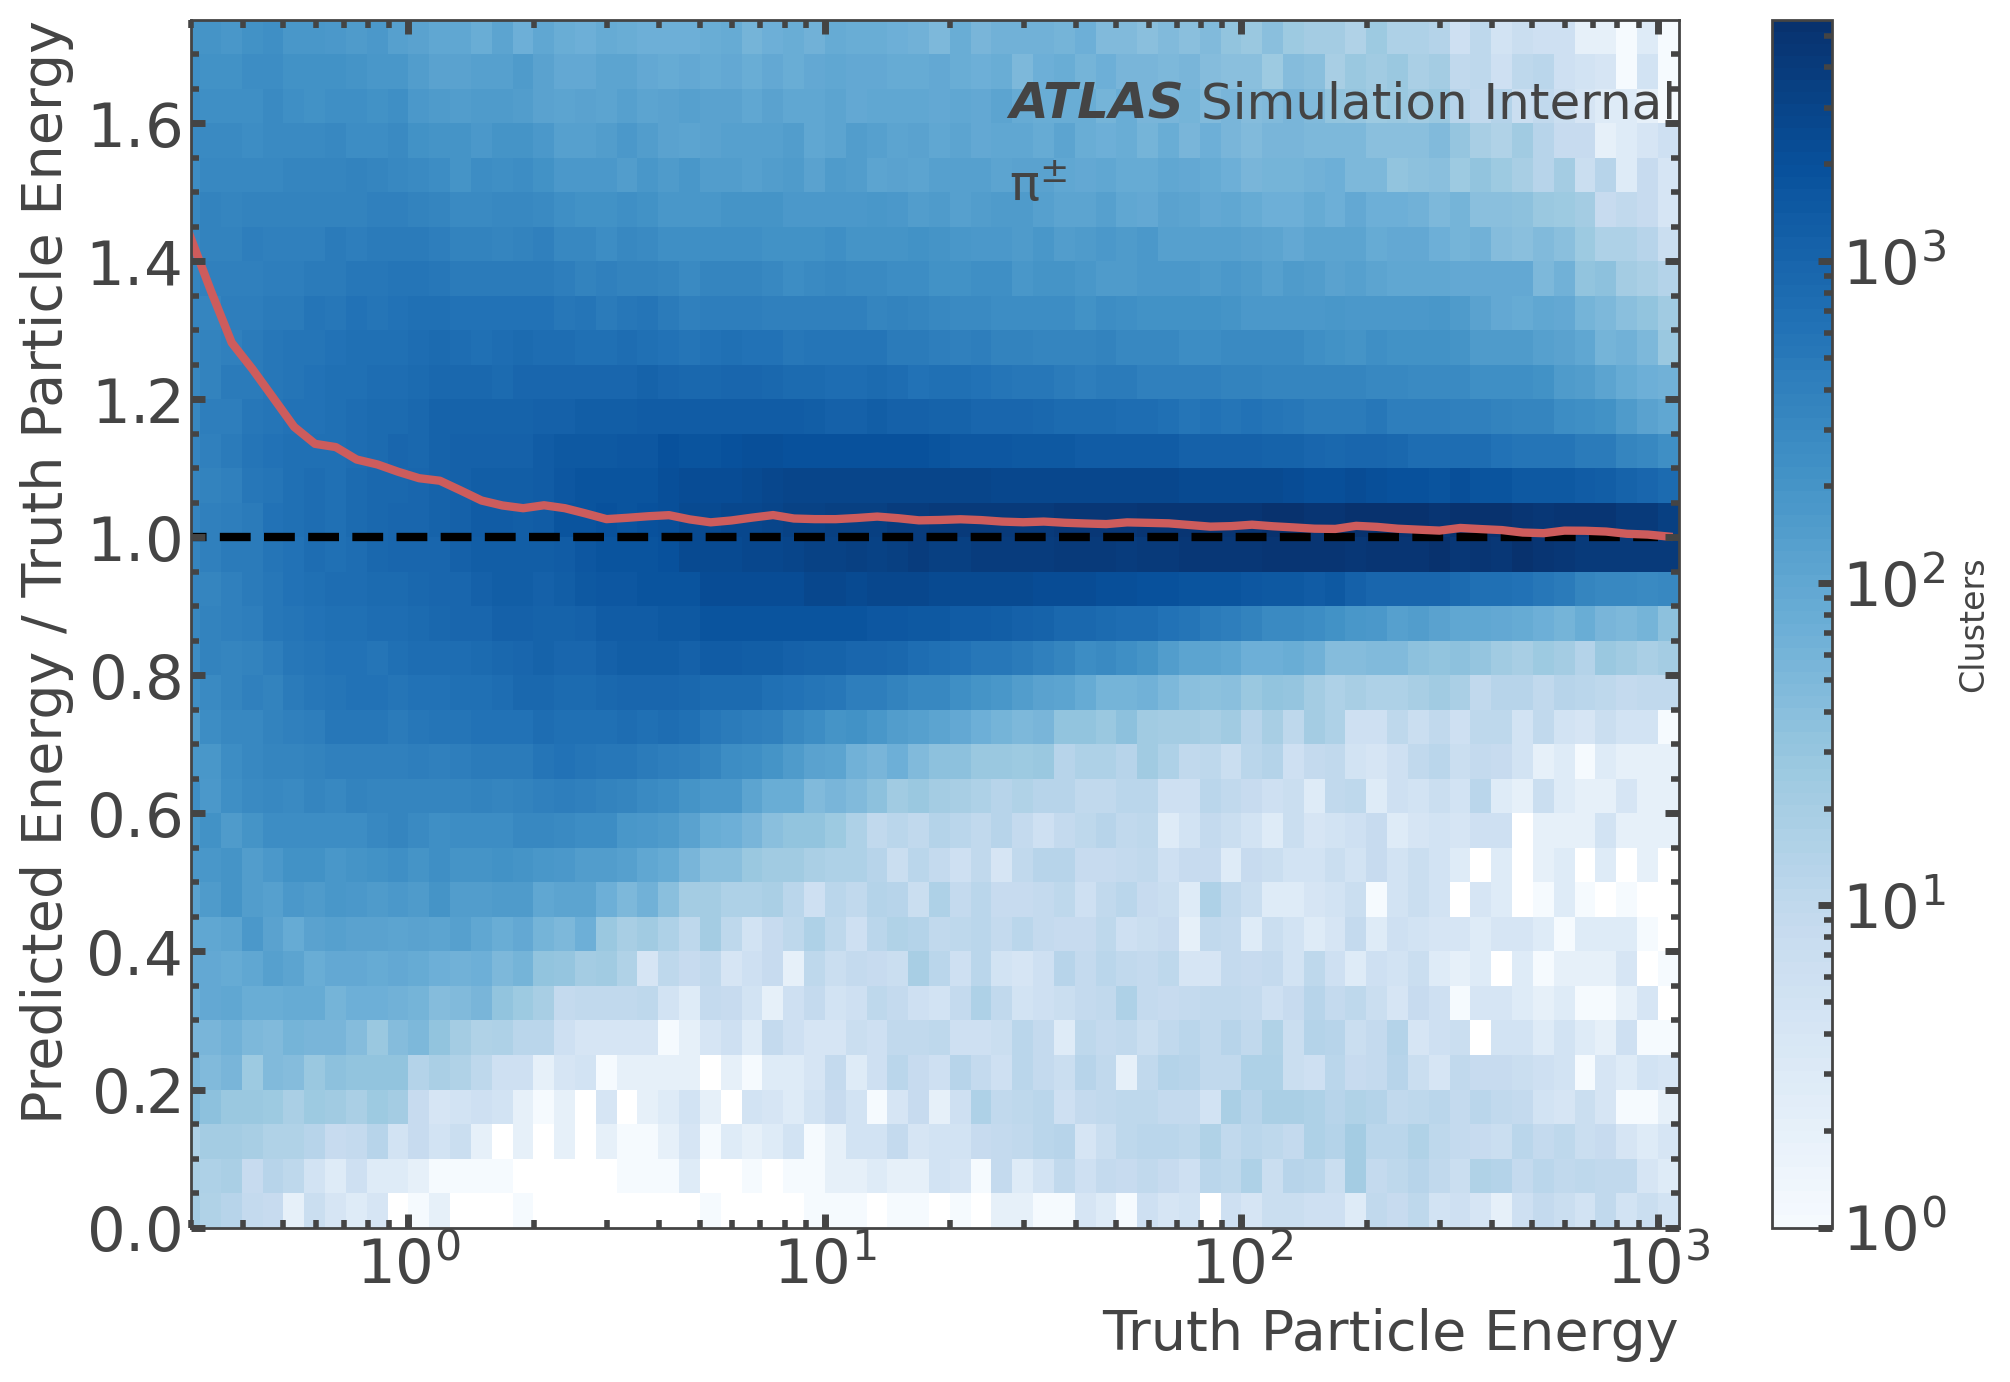


Plotting $\pi^{all}$


<Figure size 1600x1200 with 0 Axes>

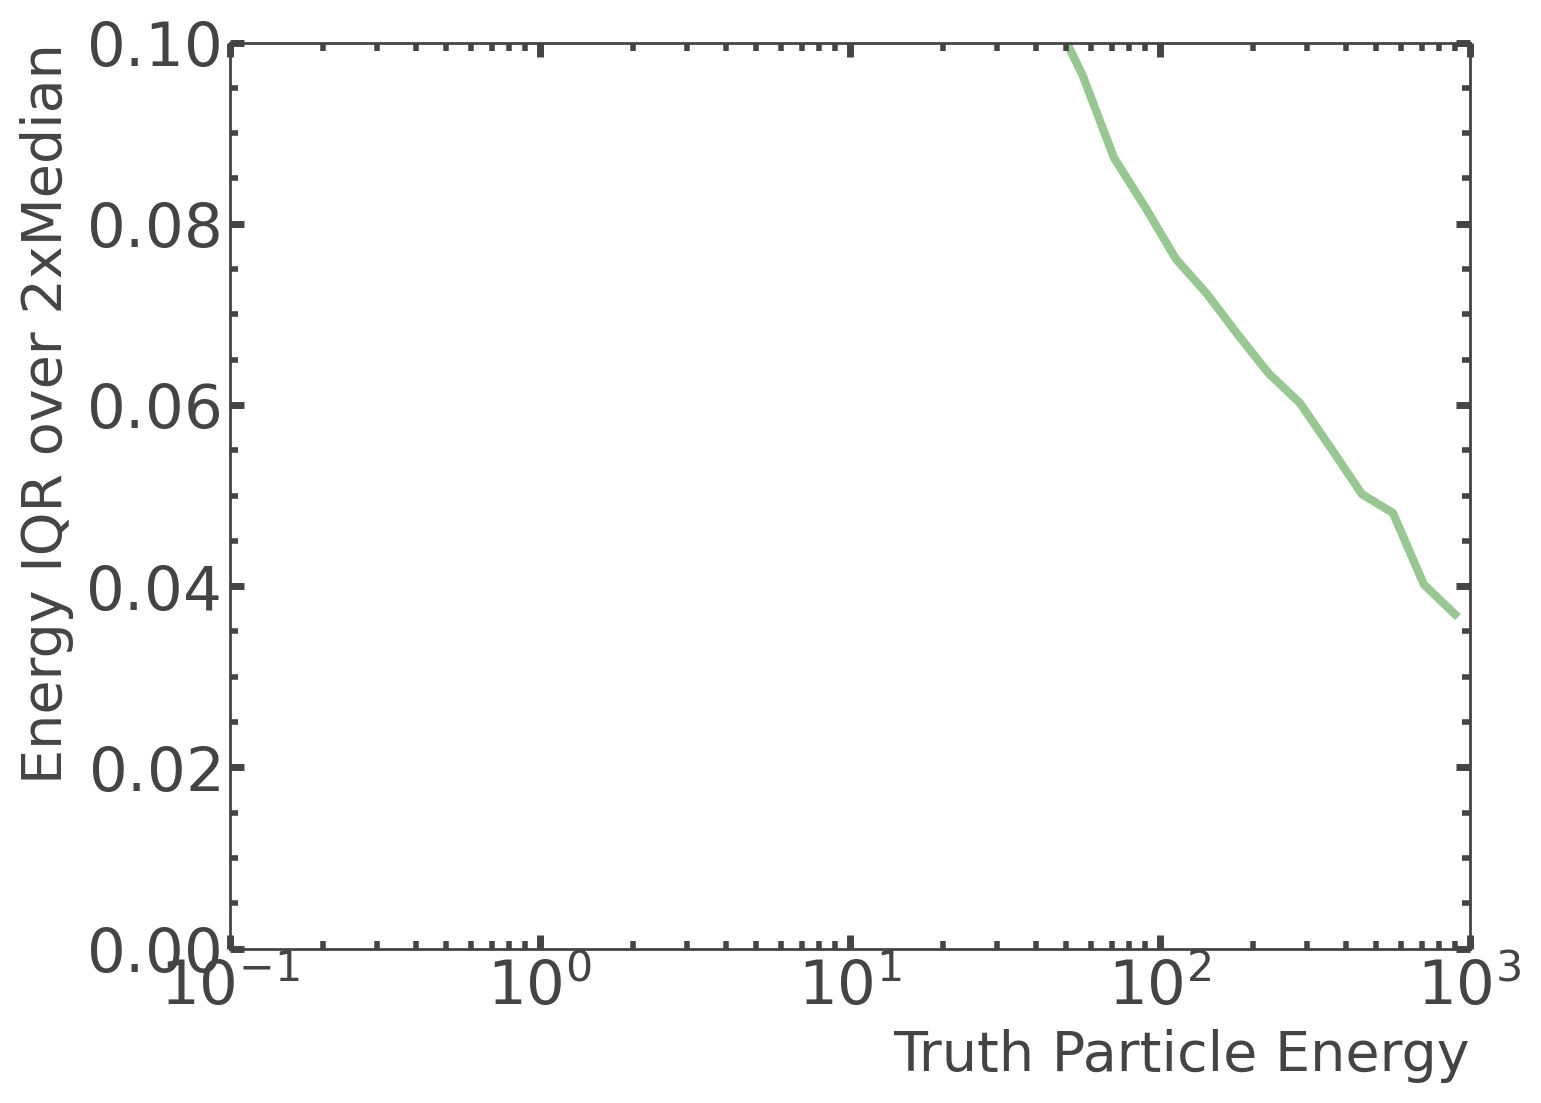


Plotting $\pi^{0}$


<Figure size 1600x1200 with 0 Axes>

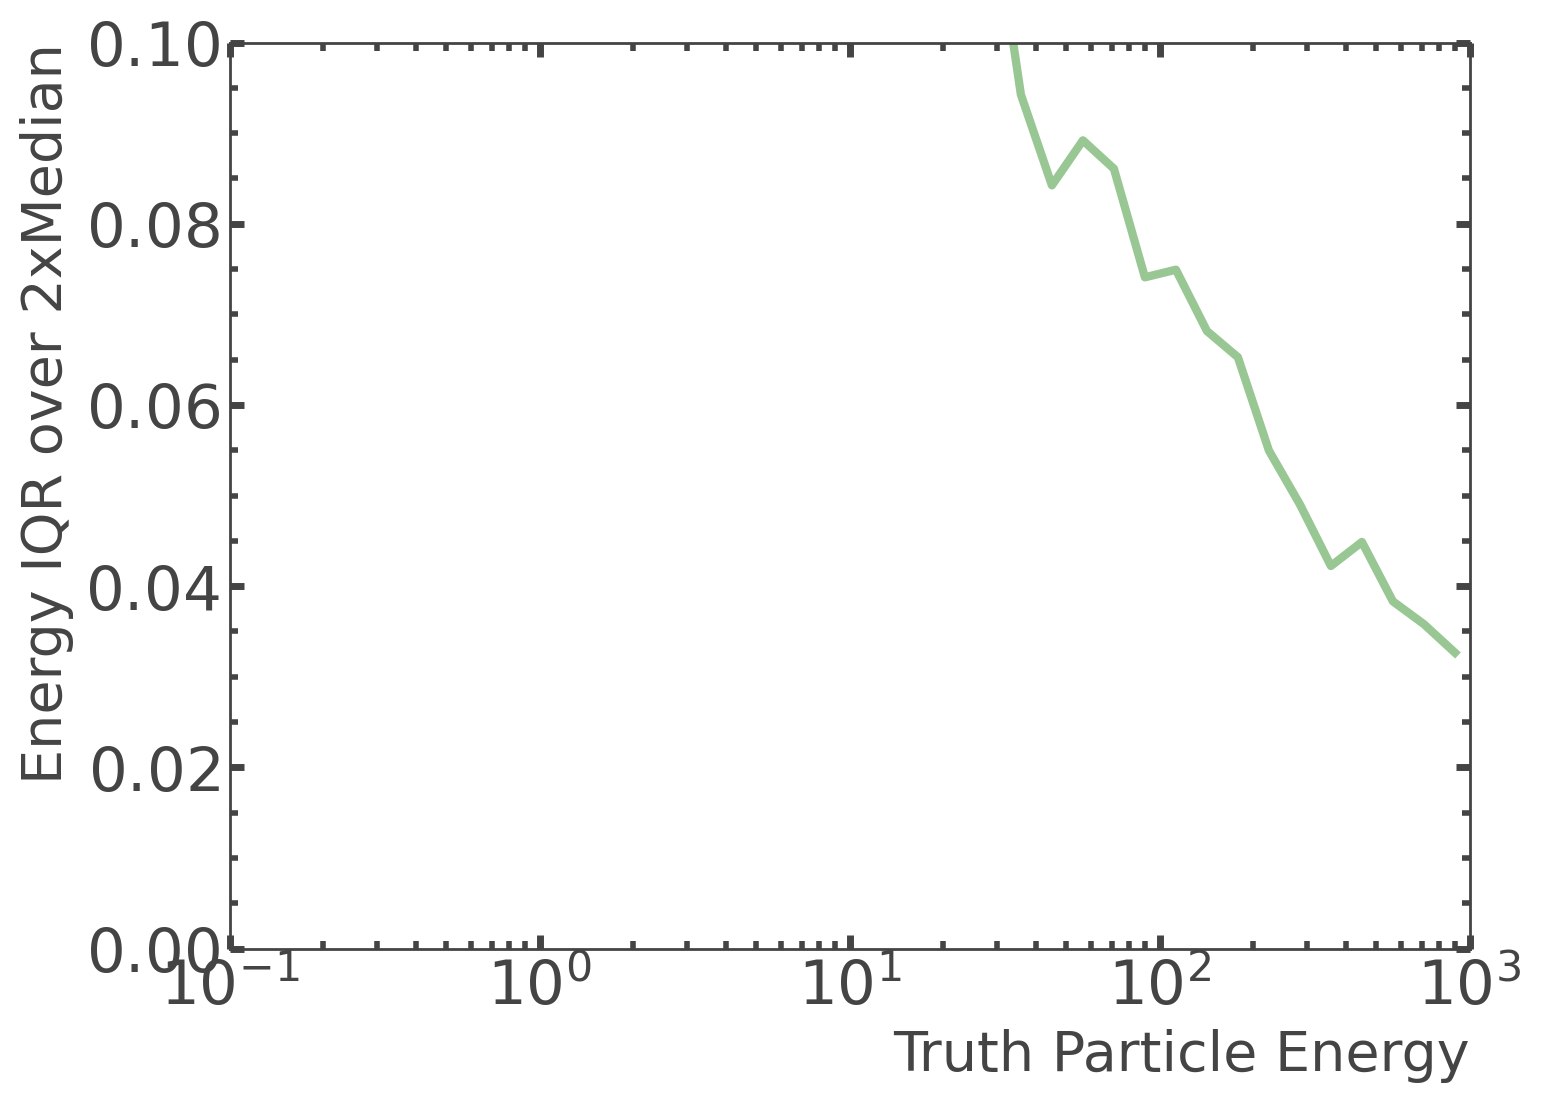


Plotting $\pi^{\pm}$


<Figure size 1600x1200 with 0 Axes>

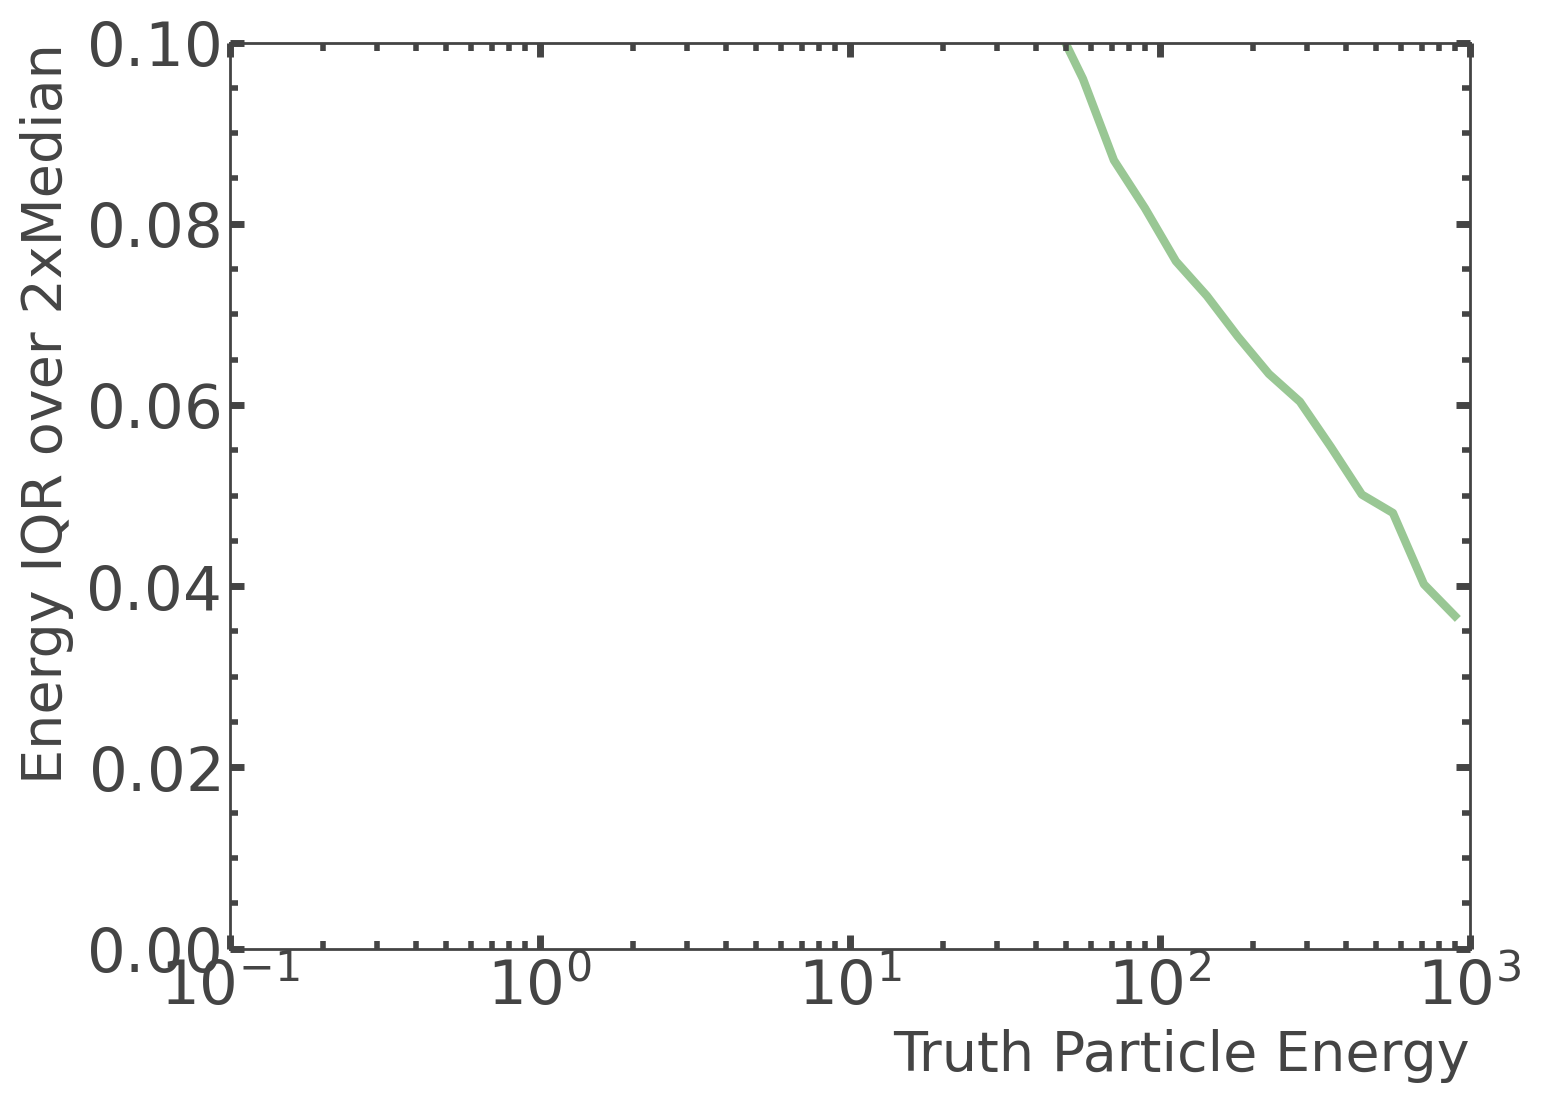

<Figure size 1600x1200 with 0 Axes>

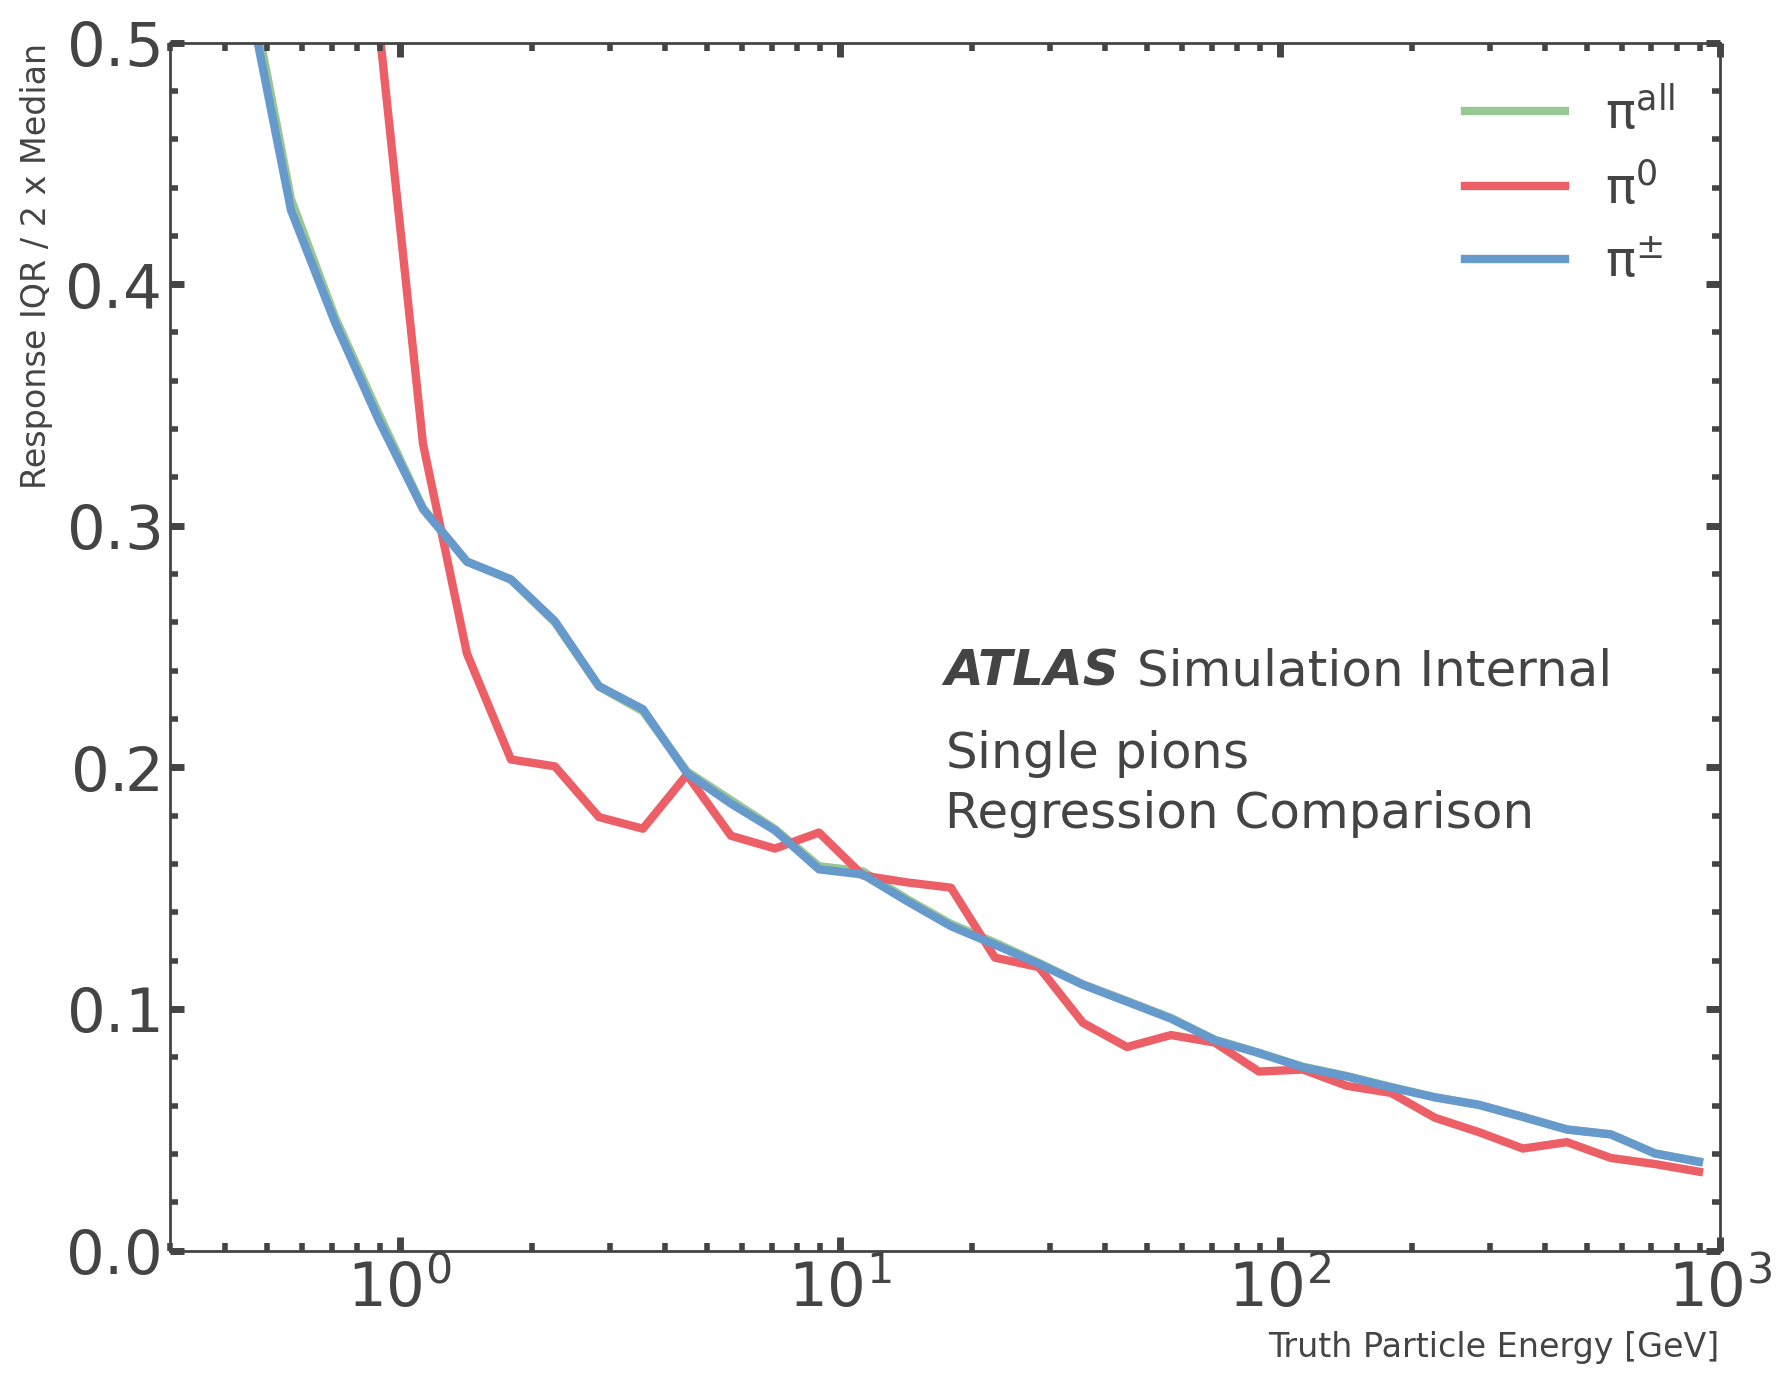

In [29]:
### EM Calib 
c_map = sns.color_palette("viridis")

pion_list = [
    '$\pi^{all}$', 
             '$\pi^{0}$', 
             '$\pi^{\pm}$'
]
sym_list = [
    '', 
            '0', 
            '+-'
           ]
blues = matplotlib.cm.viridis(np.linspace(0,1,20))
oranges = matplotlib.cm.viridis(np.linspace(0,1,20))

print('\nPlotting {}'.format(pion_list[0]))
y_true = df.cluster_calib_e
y_pred = df.energy # EM calib
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[0], 
                                        f_name=data_dir+'/regress_em_all.png'
                                       )
print('\nPlotting {}'.format(pion_list[1]))
y_true = df[df.targets_class == 0].cluster_calib_e
y_pred = df[df.targets_class == 0].energy # EM calib
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[1], 
                                        f_name=data_dir+'/regress_em_pi0.png'
                                       )
print('\nPlotting {}'.format(pion_list[2]))
y_true = df[df.targets_class == 1].cluster_calib_e
y_pred = df[df.targets_class == 1].energy # EM calib
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[2], 
                                        f_name=data_dir+'/regress_em_pion.png'
                                       )

### IQR Plots
iqr = []
print('\nPlotting {}'.format(pion_list[0]))
y_true = df.cluster_calib_e
y_pred = df.energy # EM calib
y_ratio = y_pred/y_true
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

if "targets_class" in df.keys():
    print('\nPlotting {}'.format(pion_list[1]))
    y_true = df[df.targets_class == 0].cluster_calib_e
    y_pred = df[df.targets_class == 0].energy # EM calib
    y_ratio = y_pred/y_true
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
    iqr.append(iqr_curr)

    print('\nPlotting {}'.format(pion_list[2]))
    y_true = df[df.targets_class == 1].cluster_calib_e
    y_pred = df[df.targets_class == 1].energy # EM calib
    y_ratio = y_pred/y_true
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')

iqr.append(iqr_curr)
pu.lineOverlay(xcenter=xcenter, lines = iqr[:],  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
            labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                r'$\pi^{\pm}$'],
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
            y_max = 0.5,  # default = 0.5
               x_min = .3,
            linestyles = [
                    'solid', 
                    'solid', 
                'solid'
            ],  
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Single $pions$'},
                        {'x': 0.5, 'y': 0.35,  'text': 'Regression Comparison'}],
              figfile=data_dir+'/regress_em_iqr.png')
np.savez(data_dir+'/iqr_em.npz', iqr=iqr, xcenter=xcenter)


### LCW Calib 
print('\nPlotting {}'.format(pion_list[0]))
y_true = df.cluster_calib_e
y_pred = df.energy*df.cluster_had_weight # LCW calib
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[0], 
                                        f_name=data_dir+'/regress_lcw_all.png'
                                       )
print('\nPlotting {}'.format(pion_list[1]))
y_true = df[df.targets_class == 0].cluster_calib_e
y_pred = df[df.targets_class == 0].energy*df[df.targets_class == 0].cluster_had_weight # LCW calib
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[1], 
                                        f_name=data_dir+'/regress_lcw_pi0.png'
                                       )
print('\nPlotting {}'.format(pion_list[2]))
y_true = df[df.targets_class == 1].cluster_calib_e
y_pred = df[df.targets_class == 1].energy*df[df.targets_class == 1].cluster_had_weight # LCW calib
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[2], 
                                        f_name=data_dir+'/regress_lcw_pion.png'
                                       )

### IQR Plots
iqr = []
print('\nPlotting {}'.format(pion_list[0]))
y_true = df.cluster_calib_e
y_pred = df.energy*df.cluster_had_weight # LCW calib
y_ratio = y_pred/y_true
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

if "targets_class" in df.keys():
    print('\nPlotting {}'.format(pion_list[1]))
    y_true = df[df.targets_class == 0].cluster_calib_e
    y_pred = df[df.targets_class == 0].energy*df[df.targets_class == 0].cluster_had_weight # LCW calib
    y_ratio = y_pred/y_true
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
    iqr.append(iqr_curr)

    print('\nPlotting {}'.format(pion_list[2]))
    y_true = df[df.targets_class == 1].cluster_calib_e
    y_pred = df[df.targets_class == 1].energy*df[df.targets_class == 1].cluster_had_weight # LCW calib
    y_ratio = y_pred/y_true
    xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')

iqr.append(iqr_curr)
pu.lineOverlay(xcenter=xcenter, lines = iqr[:],  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
            labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                r'$\pi^{\pm}$'],
            xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
            y_max = 0.5,  # default = 0.5
               x_min = .3,
            linestyles = [
                    'solid', 
                    'solid', 
                'solid'
            ],  
            atlas_x = 0.5, atlas_y = 0.5, simulation = True,
            textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Single $pions$'},
                        {'x': 0.5, 'y': 0.35,  'text': 'Regression Comparison'}],
              figfile=data_dir+'/regress_lcw_iqr.png')
np.savez(data_dir+'/iqr_lcw.npz', iqr=iqr, xcenter=xcenter)

# Extra stuff

In [ ]:
# pu.lineOverlay(xcenter=xcenter, lines=response_median,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
#                 labels = [
#                     r'$\pi^{all}$', 
#                     r'$\pi^{0}$', 
#                     r'$\pi^{\pm}$'
#                 ],
#                 xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response Median',
#                 figfile = '', # medResponse_gnBlock.png',
#                 y_max=1.2, y_min=.9, x_min = .3, colorgrouping=0,
#                 extra_lines= [[[0, 10e3], [1, 1]]],
#                 linestyles = ['solid', 'solid', 'solid'], # , 'dashed',],
#                 atlas_x = 0.05, atlas_y = 0.85, simulation = True,
#                 textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $pions$'},
#                             {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])

In [ ]:
# # set plotsytle choices here
# params = {'legend.fontsize': 24,
#           'axes.labelsize': 32}
# plt.rcParams.update(params)

# ampl.set_color_cycle('Oceanic',10)

# c_map = sns.color_palette("Blues")

# pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
# blues = matplotlib.cm.viridis(np.linspace(0,1,20))
# oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

# print('\nPlotting {}'.format(pion_list[0]))
# y_true = np.log10(df.targets_regress)
# y_pred = np.log10(df.outputs_regress)
# make_hist_plot(y_true, y_pred, pion_list[0])

# print('\nPlotting {}'.format(pion_list[1]))
# y_true = np.log10(df.targets_regress[df.targets_class==0])
# y_pred = np.log10(df.outputs_regress[df.targets_class==0])
# make_hist_plot(y_true, y_pred, pion_list[1])

# print('\nPlotting {}'.format(pion_list[2]))
# y_true = np.log10(df.targets_regress[df.targets_class==1])
# y_pred = np.log10(df.outputs_regress[df.targets_class==1])
# make_hist_plot(y_true, y_pred, pion_list[2])

In [ ]:
# iqr = []
# print('\nPlotting {}'.format(pion_list[0]))
# y_true = df.targets_regress
# y_pred = df.outputs_regress
# y_ratio = y_pred/y_true
# xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
# iqr.append(iqr_curr)

# print('\nPlotting {}'.format(pion_list[1]))
# y_true = df.targets_regress[df.targets_class==0]
# y_pred = df.outputs_regress[df.targets_class==0]
# y_ratio = y_pred/y_true
# xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
# iqr.append(iqr_curr)

# print('\nPlotting {}'.format(pion_list[2]))
# y_true = df.targets_regress[df.targets_class==1]
# y_pred = df.outputs_regress[df.targets_class==1]
# y_ratio = y_pred/y_true
# xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
# iqr.append(iqr_curr)

# # np.savez(data_dir+'/iqr.npz', response_median=iqr, xcenter=xcenter)
# # plt.savefig(data_dir+'/regress_iqr.png', dpi=300, bbox_inches='tight')

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = iqr,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                    r'$\pi^{\pm}$'],
                xlabel = 'Truth Particle Energy [GeV]', ylabel = 'Response IQR / 2 x Median',
                figfile = '', # 'iqr_gnBlock.png',
                y_max = .5, x_min = .3,
                linestyles = [
                    'solid', 
                    'solid', 'solid'
                ],  # , 'dashed',],
                atlas_x = 0.5, atlas_y = 0.375, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.275, 'text': 'Single $pions$'},
                            {'x': 0.5, 'y': 0.225,  'text': 'Regression Comparison'}])
plt.savefig(data_dir+'/iqr.png', dpi=300, bbox_inches='tight')